# Import Packages

In [1]:
import numpy as np
import math
import cv2
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Function from the lecture

In [97]:
def my_add_heat(heatmap, bbox_list, y):
    # Iterate through list of bboxes
    for i in range(len(bbox_list)):
        box = bbox_list[i]
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         print(int(y[i][0]))
        #if math.isnan(y[i][0]) == 0 and int(y[i][0]) == 1:
        if y[i][0]>0.9: 
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def give_boxes(labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        boxes.append(bbox)
    # Return the image
    return boxes    

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    boxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        boxes.append(bbox)
    # Return the image
    return img, boxes

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image

    imcopy = process_img_adv(np.copy(img), bboxes)

#     imcopy = np.copy(img2)

#     # Iterate through the bounding boxes
#     for bbox in bboxes:
#         # Draw a rectangle given bbox coordinates
#         cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
#     # Return the image copy with boxes drawn
    return imcopy

# Sliding Window Function

In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[600, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [6]:
# Load Datasets
car_names = []
car_names += glob.glob('C:/Datasets/Vehicle_Detection/vehicles/GTI_MiddleClose/image*.png')
car_names += glob.glob('C:/Datasets/Vehicle_Detection/vehicles/GTI_Far/image*.png')
car_names += glob.glob('C:/Datasets/Vehicle_Detection/vehicles/GTI_Left/image*.png')
car_names += glob.glob('C:/Datasets/Vehicle_Detection/vehicles/GTI_Right/image*.png')
car_names += glob.glob('C:/Datasets/Vehicle_Detection/vehicles/KITTI_extracted/*.png')

notcar_names = []
notcar_names += glob.glob('C:/Datasets/Vehicle_Detection/non-vehicles/GTI/image*.png')
notcar_names  += glob.glob('C:/Datasets/Vehicle_Detection/non-vehicles/Extras/extra*.png')

print('There are {} car images in the dataset.'.format(len(car_names)))
print('There are {} not car images in the dataset'.format(len(notcar_names)))

cars = []
for name in car_names:
    car = mpimg.imread(name)
#     car = np.uint8(car*255)
    cars.append(car)
notcars = []
for name in notcar_names:
    notcar = mpimg.imread(name)
#     notcar = np.uint8(notcar*255)
    notcars.append(notcar)

print(np.max(cars[0]))


There are 8792 car images in the dataset.
There are 8968 not car images in the dataset
0.694118


# Prepare Data

In [12]:
from sklearn.model_selection import train_test_split

# Define the labels vector
y = np.hstack((np.ones(len(car_names)), np.zeros(len(notcar_names))))
X = np.vstack((cars, notcars))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Train a CNN

In [ ]:
# Building and Training the model

from keras.models import Sequential
#from keras.layers import Flatten, Dense, Convolution2D
from keras import *
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dropout, Lambda, Flatten, Dense, Reshape, Input, merge, normalization
from keras.models import Model

inp = Input(shape=(64,64,3))
layer_1  = Lambda(lambda x: x - 0.5)(inp)
layer_11 = MaxPooling2D()(layer_1)
layer_2  = Conv2D(20, 3, 3, border_mode='same', activation='relu')(layer_11)
layer_3  = Conv2D(5, 1, 1,  border_mode='same', activation='relu')(layer_11)
layer_4  = Conv2D(15, 5, 5,border_mode='same', activation='relu')(layer_11)
merge_1  = merge([layer_2, layer_3, layer_4], mode = 'concat', concat_axis = -1)
max_pool = MaxPooling2D()(merge_1)
max_pool  = normalization.BatchNormalization()(max_pool)
layer_5  = Dropout(0.5)(max_pool)
layer_6  = Conv2D(25,3,3, border_mode='same', activation='relu')(layer_5)
layer_62 = MaxPooling2D()(layer_6)
layer_62  = normalization.BatchNormalization()(layer_62)
layer_7  = Flatten()(layer_62)
layer_8  = Dense(50, activation='relu')(layer_7)
layer_9  = Dropout(0.5)(layer_8)
layer_10 = Dense(20, activation='relu')(layer_9)
layer_11 = Dropout(0.5)(layer_10)
outlayer = Dense(1, activation='sigmoid')(layer_11)

model = model = Model(input=inp, output=outlayer)
model.summary()

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
checkpointer = callbacks.ModelCheckpoint(filepath='C:/SDCND/CarND-Vehicle-Detection-Project-P5/best_model_so_far.hdf5', verbose=1, save_best_only=True)
history_object = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 128, shuffle = True, nb_epoch = 10, callbacks=[checkpointer])



# My Pipeline

In [4]:
from keras.models import load_model


model = load_model('./my_model_1.hdf5')
model2= load_model('./my_model_2.hdf5')
model4= load_model('./my_model_4.hdf5')
model5= load_model('./my_model_5.hdf5')


Using TensorFlow backend.


# The Pipe

In [12]:
from scipy.misc import imresize

def pipeline(img):
    #img = img.astype(np.float32)/255-0.5
    y_dim, x_dim, depth = img.shape
    #print('The max of img is {}'.format(np.max(img)))
    outs = []
    heatmap = np.zeros_like(img[:,:,0])
    
    sizes = [(90,50,500), (75,75,500), (150,75,500), (100,100,550), (200,100,600), (125,125,600),(150,150,660), (200,200,660)] #[(25,25,3), (50,50,3), (100,100,3), (125,125,3), (150,150,3)]
    #sizes = [(150,150,3)]
    #w_size = (100,100,3)
    time1 = time.time()
    n_windows = 0
    for w_size in sizes:
        window_list = slide_window(img, x_start_stop=[600, None], y_start_stop=[350, w_size[2]], 
                        xy_window=w_size[:2], xy_overlap=(0.6, 0.6))
        n_windows += len(window_list)

#         out = draw_boxes(img*255, window_list)
#         outs.append(out)

        pics = np.empty((64,64,3))

        for window in window_list:
            if len(pics.shape) < 4:
                win = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
                win = imresize(win, (64,64,3))/255
                pics = np.stack((pics, win))
            else:
                win = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
                win = imresize(win, (64,64,3))/255
                win = np.expand_dims(win, axis=0)
                pics = np.concatenate((pics, win), axis=0)

        sol1 = model.predict(pics, batch_size=512)
#         sol2 = model2.predict(pics, batch_size=512)
#         sol4 = model4.predict(pics, batch_size=512)
#         sol5 = model5.predict(pics, batch_size=512)
#         sol = np.maximum(0, np.round(sol1)+np.round(sol2)+np.round(sol4)+np.round(sol5) -2)
#         sol = np.minimum(1, sol)
        sol = sol1
        res = np.round(sol)  
        heatmap = my_add_heat(heatmap, window_list, res)
    time2 = time.time()
    print('First net took {} many second to check {} many pictures.'.format(np.round(time2-time1,2), n_windows))
    
    return heatmap, sol, outs, res

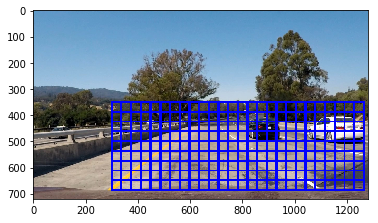

In [51]:
for out in outs:
    plt.figure()
    plt.imshow(np.uint8(out))

In [99]:
def process_img(img):   
    global lab
    global iteration
    global car_centers
    global history_boxes
    
    #img = process_img_adv(img)
    
    img = img.astype(np.float32)/255
    heatmap, sol, outs, res = pipeline(img)
    #print(np.max(heatmap))
    heatmap = apply_threshold(heatmap, 6)

    heatmaps.append(heatmap)
    if iteration < 6: #6
        iteration +=1
        return np.uint8(img*255)
    else:
        H = np.sum(heatmaps, axis=0)
        #print(np.max(H))
        H = apply_threshold(H, 30)
        heatmaps.pop(0)
        labels = label(H)
        lab.append(labels[1])
        
        boxes = give_boxes(labels) # in format (min(x),min(y); max(x),max(y))
        print('currently {} many boxes'.format(len(boxes)))
        
        
        # use belief
        time1 = time.time()
        accepted_boxes = []
        car_centers_new = []
        needed_belief = 10
        for box in boxes:
            ind = 0
            box_accepted = 0
            for car in car_centers: # (x,y,3) 
                if box[0][0] <= car[0] <= box[1][0] and box[0][1] <= car[1] <= box[1][1] and box[0][0] <= car[0]-10 <= box[1][0] and box[0][1] and box[0][0] <= car[0]+10 <= box[1][0] and box[0][1] and box[0][1] <= car[1]-10 <= box[1][1] and box[0][1] <= car[1]+10 <= box[1][1]:
                    if car[2] >= needed_belief and box_accepted == 0:
                        accepted_boxes.append(box)
                        box_accepted = 1
                    else:
                        car[2] += 1
                    car_centers_new.append(car)
                    ind += 1
            new_car = np.array([int(0.5*(box[0][0]+box[1][0])) , int(0.5*(box[0][1]+box[1][1])), 1])
            car_centers_new.append(new_car)
        
        car_centers = car_centers_new
        boxes = accepted_boxes
        time2 = time.time()
        print('After belief, still {} many boxes. It took {} many seconds.'.format(len(boxes), np.round(time2-time1,2)))
        print('There are {} centers in the centers.'.format(len(car_centers)))
        
        
        # Check the suggestions of the first neural net with an Ensemble of nets
        final_boxes = []
        margins = np.linspace(1,100,25)
        factors = [2,2.5,3,3.5]
        for box in boxes:
            predicts = []
            new_boxes = []
            for margin in margins:
                for factor in factors:
                    predict, new_box = predict_margin(img, box, int(margin), factor)
                    if np.round(predict) > 0.9:
                        predicts.append(predict)
                        new_boxes.append(new_box)
            if len(new_boxes) > 0:
                mean_box_list = np.mean(new_boxes[-4:], axis=0)
                mean_box = ((int(mean_box_list[0][0]), int(mean_box_list[0][1])),(int(mean_box_list[1][0]), int(mean_box_list[1][1])))  
                max_box = new_boxes[-1]
                mean_box = np.mean([mean_box, max_box], axis=0)
#                mean_box = new_boxes[-1]
                final_boxes.append(mean_box)
            else:                
                print('Deleted Box!')
        time3 = time.time()        
        print('{} of {} boxes survived the Ensemble-Check! It took {} many seconds.'.format(len(final_boxes), len(boxes), np.round(time3-time2, 2)))
        #draw_img, boxes = draw_labeled_bboxes(np.copy(np.uint8(img*255)), labels)
        
        
        
        if len(final_boxes) > 0:
            
            # combine boxes:
            last_boxes = []
            while len(final_boxes) > 0:
                box1 = final_boxes[0]
                merge = 0
                for i in range(1,len(final_boxes)):
                    box2 = final_boxes[i]
                    #dist = np.absolute(box1[0][0]-box2[0][0]) + np.absolute(box1[0][1]-box2[0][1]) + np.absolute(box1[1][0]-box2[1][0]) + np.absolute(box1[1][1]-box2[1][1])
                    #if dist<=80:
                    if 0.8 * box2[0][0] <= box1[0][0] <= 1.2*box2[0][0] and 0.8 * box2[0][1] <= box1[0][1] <= 1.2*box2[0][1] and 0.8 * box2[1][0] <= box1[1][0] <= 1.2*box2[1][0] and 0.8 * box2[1][1] <= box1[1][1] <= 1.2*box2[1][1]: 
                        print('Combine Boxes!')
                        merge = 1
                        box_new = ((np.minimum(box1[0][0],box2[0][0]), np.minimum(box1[0][1],box2[0][1])),(np.maximum(box1[1][0],box2[1][0]), np.maximum(box1[1][1], box2[1][1])) )
                        final_boxes.append(box_new)
                        final_boxes.pop(0)
                        final_boxes.pop(i-1)
                        break
                if merge == 0:
                    last_boxes.append(box1)
                    final_boxes.pop(0)
                    
            # smooth the result with the history
            history_boxes.append(last_boxes)
            if len(history_boxes) > 15:
                history_boxes.pop(0)
                
            really_last_boxes = []
            for box1 in last_boxes:
                mean_boxes = [box1]
                for i in range(len(history_boxes)-1):
                    for box2 in history_boxes[i]:
                        #dist = np.absolute(box1[0][0]-box2[0][0]) + np.absolute(box1[0][1]-box2[0][1]) + np.absolute(box1[1][0]-box2[1][0]) + np.absolute(box1[1][1]-box2[1][1])
                        #if dist<=80:
                        if 0.8 * box2[0][0] <= box1[0][0] <= 1.2*box2[0][0] and 0.8 * box2[0][1] <= box1[0][1] <= 1.2*box2[0][1] and 0.8 * box2[1][0] <= box1[1][0] <= 1.2*box2[1][0] and 0.8 * box2[1][1] <= box1[1][1] <= 1.2*box2[1][1]: 
                            mean_boxes.append(box2)
                the_mean = np.mean(mean_boxes, axis=0)
                really_last_boxes.append(((int(the_mean[0][0]), int(the_mean[0][1])),(int(the_mean[1][0]), int(the_mean[1][1]))))
                
            draw_img = draw_boxes(np.copy(np.uint8(img*255)), really_last_boxes)
        else:
            print('No final boxes!')
            if len(history_boxes) > 0:
                if len(history_boxes) == 1:
                    print('Just one history box! It is {}.'.format(history_boxes[0]))
                    mybox = history_boxes[0][0]
                    draw_img = draw_boxes(np.copy(np.uint8(img*255)), [( (int(mybox[0][0]),int(mybox[0][1])),(int(mybox[1][0]), int(mybox[1][1])) )] )
                else:
                    print('More than one history box!')
                    last_boxes = [history_boxes[i][j] for i in range(len(history_boxes)) for j in range(len(history_boxes[i]))]
                    really_last_boxes = []
                    while len(last_boxes) > 0:
                        box1 = last_boxes[0]
                        mean_boxes = []
                        indices = []
                        for i in range(len(last_boxes)):
                            box2 = last_boxes[i]
                            if 0.8 * box2[0][0] <= box1[0][0] <= 1.2*box2[0][0] and 0.8 * box2[0][1] <= box1[0][1] <= 1.2*box2[0][1] and 0.8 * box2[1][0] <= box1[1][0] <= 1.2*box2[1][0] and 0.8 * box2[1][1] <= box1[1][1] <= 1.2*box2[1][1]:  
                                mean_boxes.append(box2)
                                indices.append(i)
                        the_mean = np.mean(mean_boxes, axis=0)
                        really_last_boxes.append(((int(the_mean[0][0]), int(the_mean[0][1])),(int(the_mean[1][0]), int(the_mean[1][1]))))                    
                        last_boxes = [i for j, i in enumerate(last_boxes) if j not in indices]
                    print('We print the mean of the history boxes: {}'.format(really_last_boxes))
                    draw_img = draw_boxes(np.copy(np.uint8(img*255)), really_last_boxes)
            else:
                draw_img = np.uint8(img*255)
        
        iteration += 1
        return draw_img
    
def predict_margin(img, box, margin, factor):
    coord_y1 = np.maximum(box[0][1]-margin-1,0)
    coord_y2 = np.minimum(box[1][1]+margin, 719)
    coord_x1 = np.maximum(int(box[0][0]-margin*factor*1.75)-1, 0)
    coord_x2 = np.minimum(int(box[1][0]+margin*factor*0.5),1280)
    win = img[coord_y1:coord_y2, coord_x1:coord_x2]
    win = imresize(win, (64,64,3))/255
    win = np.expand_dims(win, axis=0)
    predict1 = model.predict(win)
    predict2 = model2.predict(win)
    predict4 = model4.predict(win)
    predict5 = model5.predict(win)
    predict = np.maximum(0,np.round(predict1)+np.round(predict2)+ np.round(predict4)+ np.round(predict5) -2)
    predict = np.minimum(1, predict)
    new_box = ((coord_x1, coord_y1), (coord_x2, coord_y2))
    return predict, new_box

# Creating the Video

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import *
from IPython.display import HTML

In [106]:
lab = []
iteration = 0
heatmaps = []
car_centers = []
history_boxes = []

# variables of project 4
iteration_adv = 1
left_coef = []
right_coef = []
history_n_feat = []
org_hist = []
flag_hist = []

output1 = './Test_AWS_full_3.mp4'

clip = VideoFileClip("project_video.mp4")#.subclip(15,20)

output_frame = clip.fl_image(process_img) #NOTE: this function expects color images!!
#white_clip = clip1.fl_image(check_filters)
%time output_frame.write_videofile(output1, audio=False)

clip.reader.close()
clip.audio.reader.close_proc()

First net took 0.58 many second to check 342 many pictures.
[MoviePy] >>>> Building video ./Test_AWS_full_3.mp4
[MoviePy] Writing video ./Test_AWS_full_3.mp4



  0%|          | 1/1261 [00:00<12:37,  1.66it/s]

First net took 0.59 many second to check 342 many pictures.



  0%|          | 2/1261 [00:01<12:37,  1.66it/s]

First net took 0.58 many second to check 342 many pictures.



  0%|          | 3/1261 [00:01<12:36,  1.66it/s]

First net took 0.58 many second to check 342 many pictures.



  0%|          | 4/1261 [00:02<12:38,  1.66it/s]

First net took 0.59 many second to check 342 many pictures.



  0%|          | 5/1261 [00:03<12:33,  1.67it/s]

First net took 0.58 many second to check 342 many pictures.



  0%|          | 6/1261 [00:03<12:37,  1.66it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 7/1261 [00:04<12:39,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 8/1261 [00:04<12:39,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 9/1261 [00:05<12:39,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 10/1261 [00:06<12:39,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 11/1261 [00:06<12:39,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 12/1261 [00:07<12:39,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 13/1261 [00:07<12:38,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 14/1261 [00:08<12:37,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|          | 15/1261 [00:09<12:36,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|▏         | 16/1261 [00:09<12:40,  1.64it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|▏         | 17/1261 [00:10<12:39,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  1%|▏         | 18/1261 [00:10<12:40,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 19/1261 [00:11<12:38,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 20/1261 [00:12<12:36,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 21/1261 [00:12<12:36,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 22/1261 [00:13<12:33,  1.64it/s]

First net took 0.57 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 23/1261 [00:13<12:33,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 24/1261 [00:14<12:32,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 25/1261 [00:15<12:31,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 26/1261 [00:15<12:33,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 27/1261 [00:16<12:32,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 28/1261 [00:17<12:33,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 29/1261 [00:17<12:31,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 30/1261 [00:18<12:30,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  2%|▏         | 31/1261 [00:18<12:28,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 32/1261 [00:19<12:27,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 33/1261 [00:20<12:26,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 34/1261 [00:20<12:25,  1.65it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 35/1261 [00:21<12:26,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 36/1261 [00:21<12:26,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 37/1261 [00:22<12:23,  1.65it/s]

First net took 0.57 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 38/1261 [00:23<12:23,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 39/1261 [00:23<12:24,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 40/1261 [00:24<12:23,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 41/1261 [00:24<12:25,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 42/1261 [00:25<12:23,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 43/1261 [00:26<12:39,  1.60it/s]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  3%|▎         | 44/1261 [00:26<12:33,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▎         | 45/1261 [00:27<12:28,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▎         | 46/1261 [00:28<12:24,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▎         | 47/1261 [00:28<12:22,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 48/1261 [00:29<12:20,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 49/1261 [00:29<12:20,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 50/1261 [00:30<12:18,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 51/1261 [00:31<12:19,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 52/1261 [00:31<12:23,  1.63it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 53/1261 [00:32<12:20,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 54/1261 [00:32<12:19,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 55/1261 [00:33<12:20,  1.63it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  4%|▍         | 56/1261 [00:34<12:35,  1.60it/s]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 57/1261 [00:34<12:28,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 58/1261 [00:35<12:32,  1.60it/s]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 59/1261 [00:36<12:25,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 60/1261 [00:36<12:20,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 61/1261 [00:37<12:18,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 62/1261 [00:37<12:15,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▍         | 63/1261 [00:38<12:26,  1.60it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▌         | 64/1261 [00:39<12:36,  1.58it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▌         | 65/1261 [00:39<12:28,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▌         | 66/1261 [00:40<12:31,  1.59it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▌         | 67/1261 [00:41<12:36,  1.58it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▌         | 68/1261 [00:41<12:38,  1.57it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  5%|▌         | 69/1261 [00:42<12:29,  1.59it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 70/1261 [00:42<12:22,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 71/1261 [00:43<12:20,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 72/1261 [00:44<12:29,  1.59it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 73/1261 [00:44<12:23,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 74/1261 [00:45<12:26,  1.59it/s]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 75/1261 [00:46<12:23,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 76/1261 [00:46<12:16,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 77/1261 [00:47<12:11,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▌         | 78/1261 [00:47<12:16,  1.61it/s]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▋         | 79/1261 [00:48<12:14,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▋         | 80/1261 [00:49<12:10,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  6%|▋         | 81/1261 [00:49<12:08,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 82/1261 [00:50<12:15,  1.60it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 83/1261 [00:51<12:13,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 84/1261 [00:51<12:11,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 85/1261 [00:52<12:16,  1.60it/s]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 86/1261 [00:52<12:15,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 87/1261 [00:53<12:12,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 88/1261 [00:54<12:09,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 89/1261 [00:54<12:07,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 90/1261 [00:55<12:02,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 91/1261 [00:55<12:02,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 92/1261 [00:56<11:58,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 93/1261 [00:57<11:54,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  7%|▋         | 94/1261 [00:57<11:52,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 95/1261 [00:58<12:06,  1.61it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 96/1261 [00:59<11:59,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 97/1261 [00:59<12:13,  1.59it/s]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 98/1261 [01:00<12:06,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 99/1261 [01:00<12:02,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 100/1261 [01:01<11:58,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 101/1261 [01:02<11:56,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 102/1261 [01:02<11:51,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 103/1261 [01:03<11:51,  1.63it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 104/1261 [01:04<11:49,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 105/1261 [01:04<11:52,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 106/1261 [01:05<11:49,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  8%|▊         | 107/1261 [01:05<11:47,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▊         | 108/1261 [01:06<11:45,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▊         | 109/1261 [01:07<11:59,  1.60it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▊         | 110/1261 [01:07<12:06,  1.58it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 111/1261 [01:08<12:01,  1.59it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 112/1261 [01:08<11:54,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 113/1261 [01:09<11:52,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 114/1261 [01:10<11:52,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 115/1261 [01:10<11:48,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 116/1261 [01:11<11:47,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 117/1261 [01:12<11:45,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 118/1261 [01:12<11:45,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



  9%|▉         | 119/1261 [01:13<11:42,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 120/1261 [01:13<11:41,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 121/1261 [01:14<11:40,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 122/1261 [01:15<11:38,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 123/1261 [01:15<11:35,  1.64it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 124/1261 [01:16<11:43,  1.62it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 125/1261 [01:17<11:41,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|▉         | 126/1261 [01:17<11:40,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|█         | 127/1261 [01:18<11:36,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|█         | 128/1261 [01:18<11:45,  1.61it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|█         | 129/1261 [01:19<11:41,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|█         | 130/1261 [01:20<11:47,  1.60it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|█         | 131/1261 [01:20<11:45,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 10%|█         | 132/1261 [01:21<11:42,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 133/1261 [01:21<11:39,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 134/1261 [01:22<11:36,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 135/1261 [01:23<11:33,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 136/1261 [01:23<11:34,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 137/1261 [01:24<11:30,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 138/1261 [01:25<11:29,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 139/1261 [01:25<11:28,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 140/1261 [01:26<11:29,  1.63it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█         | 141/1261 [01:26<11:31,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█▏        | 142/1261 [01:27<11:30,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█▏        | 143/1261 [01:28<11:27,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█▏        | 144/1261 [01:28<11:29,  1.62it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 11%|█▏        | 145/1261 [01:29<11:26,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 146/1261 [01:29<11:24,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 147/1261 [01:30<11:30,  1.61it/s]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 148/1261 [01:31<11:31,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 149/1261 [01:31<11:27,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 150/1261 [01:32<11:22,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 151/1261 [01:33<11:19,  1.63it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 152/1261 [01:33<11:31,  1.60it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 153/1261 [01:34<11:37,  1.59it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 154/1261 [01:34<11:33,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 155/1261 [01:35<11:28,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 156/1261 [01:36<11:25,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 12%|█▏        | 157/1261 [01:36<11:20,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 158/1261 [01:37<11:18,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 159/1261 [01:38<11:18,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 160/1261 [01:38<11:29,  1.60it/s]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 161/1261 [01:39<11:24,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 162/1261 [01:39<11:19,  1.62it/s]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 163/1261 [01:40<11:25,  1.60it/s]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 164/1261 [01:41<11:33,  1.58it/s]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 165/1261 [01:41<11:26,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 166/1261 [01:42<11:29,  1.59it/s]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 167/1261 [01:43<11:22,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 168/1261 [01:43<11:22,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 4 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 169/1261 [01:44<11:20,  1.61it/s]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 5 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 13%|█▎        | 170/1261 [01:44<11:16,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 6 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▎        | 171/1261 [01:45<11:21,  1.60it/s]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 8 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▎        | 172/1261 [01:46<11:29,  1.58it/s]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 9 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▎        | 173/1261 [01:46<11:22,  1.59it/s]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 10 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 174/1261 [01:47<11:17,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 12 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 175/1261 [01:48<11:21,  1.59it/s]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 14 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 176/1261 [01:48<11:22,  1.59it/s]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 7 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 177/1261 [01:49<11:21,  1.59it/s]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 9 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 178/1261 [01:49<11:18,  1.60it/s]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 10 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 179/1261 [01:50<11:15,  1.60it/s]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 12 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 180/1261 [01:51<11:12,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 14 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!



 14%|█▍        | 181/1261 [01:51<11:11,  1.61it/s]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 16 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!


First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 18 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 14%|█▍        | 182/1261 [01:54<19:49,  1.10s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 20 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 15%|█▍        | 183/1261 [01:56<25:52,  1.44s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 22 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 15%|█▍        | 184/1261 [01:58<29:59,  1.67s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 24 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 15%|█▍        | 185/1261 [02:00<32:49,  1.83s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 26 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 15%|█▍        | 186/1261 [02:03<40:16,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 28 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.92 many seconds.



 15%|█▍        | 187/1261 [02:07<45:11,  2.52s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 30 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.96 many seconds.



 15%|█▍        | 188/1261 [02:10<48:51,  2.73s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 32 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.94 many seconds.



 15%|█▍        | 189/1261 [02:13<51:24,  2.88s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 34 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 15%|█▌        | 190/1261 [02:16<53:01,  2.97s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 36 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.93 many seconds.



 15%|█▌        | 191/1261 [02:19<54:04,  3.03s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 38 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.94 many seconds.



 15%|█▌        | 192/1261 [02:23<54:53,  3.08s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 40 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 15%|█▌        | 193/1261 [02:26<55:31,  3.12s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 42 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 15%|█▌        | 194/1261 [02:29<56:00,  3.15s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 44 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 15%|█▌        | 195/1261 [02:32<56:13,  3.17s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 46 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 16%|█▌        | 196/1261 [02:35<56:22,  3.18s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 16%|█▌        | 197/1261 [02:39<56:28,  3.18s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 16%|█▌        | 198/1261 [02:42<56:39,  3.20s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 16%|█▌        | 199/1261 [02:45<56:46,  3.21s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.96 many seconds.



 16%|█▌        | 200/1261 [02:48<56:48,  3.21s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 16%|█▌        | 201/1261 [02:52<56:53,  3.22s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 16%|█▌        | 202/1261 [02:55<56:52,  3.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 16%|█▌        | 203/1261 [02:58<56:47,  3.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 16%|█▌        | 204/1261 [03:01<56:45,  3.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.96 many seconds.



 16%|█▋        | 205/1261 [03:04<56:40,  3.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 66 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 16%|█▋        | 206/1261 [03:08<56:37,  3.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 16%|█▋        | 207/1261 [03:11<56:35,  3.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 16%|█▋        | 208/1261 [03:14<56:36,  3.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 17%|█▋        | 209/1261 [03:17<56:33,  3.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 17%|█▋        | 210/1261 [03:21<56:31,  3.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 17%|█▋        | 211/1261 [03:24<56:26,  3.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 17%|█▋        | 212/1261 [03:27<56:35,  3.24s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 17%|█▋        | 213/1261 [03:30<56:44,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 17%|█▋        | 214/1261 [03:34<56:46,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 17%|█▋        | 215/1261 [03:37<56:31,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 17%|█▋        | 216/1261 [03:40<56:30,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 17%|█▋        | 217/1261 [03:43<56:18,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 90 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 17%|█▋        | 218/1261 [03:46<56:15,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 92 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 17%|█▋        | 219/1261 [03:50<56:17,  3.24s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 94 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 17%|█▋        | 220/1261 [03:53<56:22,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 96 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 18%|█▊        | 221/1261 [03:56<56:18,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 98 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 18%|█▊        | 222/1261 [03:59<56:08,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 100 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 18%|█▊        | 223/1261 [04:03<56:01,  3.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 102 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 18%|█▊        | 224/1261 [04:06<55:51,  3.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 104 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 18%|█▊        | 225/1261 [04:09<55:48,  3.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 106 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 18%|█▊        | 226/1261 [04:12<55:41,  3.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 108 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 18%|█▊        | 227/1261 [04:16<55:45,  3.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 110 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 18%|█▊        | 228/1261 [04:19<55:47,  3.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 112 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 18%|█▊        | 229/1261 [04:22<55:55,  3.25s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 114 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 18%|█▊        | 230/1261 [04:26<56:44,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 116 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 18%|█▊        | 231/1261 [04:29<56:34,  3.30s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 118 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 18%|█▊        | 232/1261 [04:32<56:27,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 120 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 18%|█▊        | 233/1261 [04:35<56:16,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 122 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 19%|█▊        | 234/1261 [04:39<56:06,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 124 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 19%|█▊        | 235/1261 [04:42<56:00,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 126 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 19%|█▊        | 236/1261 [04:45<55:58,  3.28s/it]

First net took 0.57 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 128 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 19%|█▉        | 237/1261 [04:48<55:54,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 130 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 19%|█▉        | 238/1261 [04:52<55:55,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 132 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 19%|█▉        | 239/1261 [04:55<55:55,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 134 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 19%|█▉        | 240/1261 [04:58<55:52,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 136 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 19%|█▉        | 241/1261 [05:02<55:46,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 138 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 19%|█▉        | 242/1261 [05:05<55:48,  3.29s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 140 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 19%|█▉        | 243/1261 [05:08<55:51,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 142 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 19%|█▉        | 244/1261 [05:12<55:48,  3.29s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 144 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 19%|█▉        | 245/1261 [05:15<55:46,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 146 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 20%|█▉        | 246/1261 [05:18<55:42,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 148 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 20%|█▉        | 247/1261 [05:21<55:40,  3.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 150 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 20%|█▉        | 248/1261 [05:25<55:33,  3.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 152 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 20%|█▉        | 249/1261 [05:28<55:23,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 154 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 20%|█▉        | 250/1261 [05:31<55:15,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 156 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 20%|█▉        | 251/1261 [05:34<55:05,  3.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 20%|█▉        | 252/1261 [05:38<55:04,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 160 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 20%|██        | 253/1261 [05:41<55:04,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 162 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 20%|██        | 254/1261 [05:44<54:58,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 164 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 20%|██        | 255/1261 [05:48<55:01,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 166 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 20%|██        | 256/1261 [05:51<55:06,  3.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 168 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.07 many seconds.



 20%|██        | 257/1261 [05:54<55:12,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 170 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 20%|██        | 258/1261 [05:58<55:02,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 172 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 21%|██        | 259/1261 [06:01<54:57,  3.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 174 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 21%|██        | 260/1261 [06:04<54:50,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 176 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 21%|██        | 261/1261 [06:07<54:44,  3.28s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 178 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 21%|██        | 262/1261 [06:11<54:46,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 180 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 21%|██        | 263/1261 [06:14<54:38,  3.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 182 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 21%|██        | 264/1261 [06:17<54:38,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 184 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 21%|██        | 265/1261 [06:21<54:40,  3.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 186 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 21%|██        | 266/1261 [06:24<54:31,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 188 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 21%|██        | 267/1261 [06:27<54:25,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 190 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 21%|██▏       | 268/1261 [06:30<54:25,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 192 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 21%|██▏       | 269/1261 [06:34<54:12,  3.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 194 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 21%|██▏       | 270/1261 [06:37<54:08,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 196 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 21%|██▏       | 271/1261 [06:40<54:01,  3.27s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 198 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 22%|██▏       | 272/1261 [06:43<54:04,  3.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 200 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 22%|██▏       | 273/1261 [06:47<53:57,  3.28s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 202 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.09 many seconds.



 22%|██▏       | 274/1261 [06:50<54:19,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 204 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 22%|██▏       | 275/1261 [06:53<54:15,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 206 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.07 many seconds.



 22%|██▏       | 276/1261 [06:57<54:18,  3.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 208 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.07 many seconds.



 22%|██▏       | 277/1261 [07:00<54:16,  3.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 210 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 22%|██▏       | 278/1261 [07:03<54:16,  3.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 212 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.11 many seconds.



 22%|██▏       | 279/1261 [07:07<54:28,  3.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 111 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 22%|██▏       | 280/1261 [07:09<49:21,  3.02s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 113 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 22%|██▏       | 281/1261 [07:11<45:43,  2.80s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 115 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 22%|██▏       | 282/1261 [07:14<43:10,  2.65s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 117 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 22%|██▏       | 283/1261 [07:16<41:25,  2.54s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 114 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 23%|██▎       | 284/1261 [07:18<40:16,  2.47s/it]

First net took 0.57 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 115 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 23%|██▎       | 285/1261 [07:21<39:19,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 116 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 23%|██▎       | 286/1261 [07:23<38:37,  2.38s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 117 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 23%|██▎       | 287/1261 [07:25<38:19,  2.36s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 118 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 23%|██▎       | 288/1261 [07:27<38:01,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 119 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 23%|██▎       | 289/1261 [07:30<37:40,  2.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 119 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 23%|██▎       | 290/1261 [07:32<37:32,  2.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 120 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 23%|██▎       | 291/1261 [07:34<37:19,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 121 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 23%|██▎       | 292/1261 [07:37<37:48,  2.34s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 122 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.06 many seconds.



 23%|██▎       | 293/1261 [07:39<37:45,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 123 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 23%|██▎       | 294/1261 [07:41<37:26,  2.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 124 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 23%|██▎       | 295/1261 [07:44<37:12,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 125 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 23%|██▎       | 296/1261 [07:46<37:05,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 126 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 24%|██▎       | 297/1261 [07:48<36:56,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 127 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 24%|██▎       | 298/1261 [07:51<36:54,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 128 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 24%|██▎       | 299/1261 [07:53<37:00,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 129 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 24%|██▍       | 300/1261 [07:55<36:53,  2.30s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 130 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 24%|██▍       | 301/1261 [07:57<36:53,  2.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 131 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.06 many seconds.



 24%|██▍       | 302/1261 [08:00<36:52,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 132 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 24%|██▍       | 303/1261 [08:02<36:44,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 133 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 24%|██▍       | 304/1261 [08:04<36:43,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 134 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 24%|██▍       | 305/1261 [08:07<36:37,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 135 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 24%|██▍       | 306/1261 [08:09<36:33,  2.30s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 136 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 24%|██▍       | 307/1261 [08:11<36:40,  2.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 137 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 24%|██▍       | 308/1261 [08:14<36:35,  2.30s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 138 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▍       | 309/1261 [08:16<36:33,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 139 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▍       | 310/1261 [08:18<36:24,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 140 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 25%|██▍       | 311/1261 [08:20<36:21,  2.30s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 141 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▍       | 312/1261 [08:23<36:19,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 142 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▍       | 313/1261 [08:25<36:12,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 143 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 25%|██▍       | 314/1261 [08:27<36:23,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 144 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 25%|██▍       | 315/1261 [08:30<36:13,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 145 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▌       | 316/1261 [08:32<36:05,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 146 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 25%|██▌       | 317/1261 [08:34<36:04,  2.29s/it]

First net took 0.64 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 147 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▌       | 318/1261 [08:37<36:12,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 148 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 25%|██▌       | 319/1261 [08:39<36:07,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 149 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.06 many seconds.



 25%|██▌       | 320/1261 [08:41<36:06,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 150 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 25%|██▌       | 321/1261 [08:43<36:00,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 151 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 26%|██▌       | 322/1261 [08:46<35:50,  2.29s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 152 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 26%|██▌       | 323/1261 [08:48<35:57,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 153 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 26%|██▌       | 324/1261 [08:50<35:48,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 151 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 26%|██▌       | 325/1261 [08:53<35:45,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 152 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 26%|██▌       | 326/1261 [08:55<35:43,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 153 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 26%|██▌       | 327/1261 [08:57<35:41,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 154 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 26%|██▌       | 328/1261 [08:59<35:38,  2.29s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 155 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 26%|██▌       | 329/1261 [09:02<35:43,  2.30s/it]

First net took 0.63 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 156 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 26%|██▌       | 330/1261 [09:04<35:50,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 157 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 26%|██▌       | 331/1261 [09:06<35:41,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 26%|██▋       | 332/1261 [09:09<35:39,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 153 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 26%|██▋       | 333/1261 [09:11<35:33,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 154 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 26%|██▋       | 334/1261 [09:13<35:26,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 155 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 27%|██▋       | 335/1261 [09:16<35:24,  2.29s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 156 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 27%|██▋       | 336/1261 [09:18<35:20,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 157 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 27%|██▋       | 337/1261 [09:20<35:18,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 27%|██▋       | 338/1261 [09:22<35:17,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 159 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 27%|██▋       | 339/1261 [09:25<35:09,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 160 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 27%|██▋       | 340/1261 [09:27<35:01,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 143 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 27%|██▋       | 341/1261 [09:29<34:54,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 125 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 27%|██▋       | 342/1261 [09:32<34:49,  2.27s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 126 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 27%|██▋       | 343/1261 [09:34<34:51,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 127 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 27%|██▋       | 344/1261 [09:36<34:50,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 128 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 27%|██▋       | 345/1261 [09:38<34:42,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 129 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 27%|██▋       | 346/1261 [09:41<34:36,  2.27s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 130 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 28%|██▊       | 347/1261 [09:43<34:37,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 131 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 28%|██▊       | 348/1261 [09:45<34:32,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 132 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 28%|██▊       | 349/1261 [09:47<34:23,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 133 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 28%|██▊       | 350/1261 [09:50<34:22,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 134 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 28%|██▊       | 351/1261 [09:52<34:28,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 135 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 28%|██▊       | 352/1261 [09:54<34:57,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 136 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 28%|██▊       | 353/1261 [09:57<34:43,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 137 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 28%|██▊       | 354/1261 [09:59<34:38,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 138 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 28%|██▊       | 355/1261 [10:01<34:29,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 139 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 28%|██▊       | 356/1261 [10:03<34:25,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 140 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 28%|██▊       | 357/1261 [10:06<34:19,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 132 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 28%|██▊       | 358/1261 [10:08<34:13,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 133 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 28%|██▊       | 359/1261 [10:10<34:09,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 93 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 29%|██▊       | 360/1261 [10:12<34:03,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 94 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 29%|██▊       | 361/1261 [10:15<33:57,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 29%|██▊       | 362/1261 [10:17<33:54,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 29%|██▉       | 363/1261 [10:19<33:51,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 29%|██▉       | 364/1261 [10:22<33:46,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 29%|██▉       | 365/1261 [10:24<33:41,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 29%|██▉       | 366/1261 [10:26<33:40,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 29%|██▉       | 367/1261 [10:28<33:36,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 29%|██▉       | 368/1261 [10:31<33:34,  2.26s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 29%|██▉       | 369/1261 [10:33<33:40,  2.26s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 29%|██▉       | 370/1261 [10:35<33:38,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 29%|██▉       | 371/1261 [10:37<33:31,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 30%|██▉       | 372/1261 [10:40<33:33,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 85 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 30%|██▉       | 373/1261 [10:42<33:33,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 30%|██▉       | 374/1261 [10:44<33:31,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 87 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 30%|██▉       | 375/1261 [10:46<33:25,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 30%|██▉       | 376/1261 [10:49<33:20,  2.26s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 30%|██▉       | 377/1261 [10:51<33:24,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 30%|██▉       | 378/1261 [10:53<33:20,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 30%|███       | 379/1261 [10:55<33:18,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 30%|███       | 380/1261 [10:58<33:09,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 30%|███       | 381/1261 [11:00<33:05,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 30%|███       | 382/1261 [11:02<33:07,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 30%|███       | 383/1261 [11:04<33:03,  2.26s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 30%|███       | 384/1261 [11:07<33:03,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 44 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 31%|███       | 385/1261 [11:09<32:59,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 31%|███       | 386/1261 [11:11<32:57,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 46 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 31%|███       | 387/1261 [11:14<32:50,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 31%|███       | 388/1261 [11:16<32:49,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 31%|███       | 389/1261 [11:18<32:43,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 31%|███       | 390/1261 [11:20<32:38,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 44 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 31%|███       | 391/1261 [11:23<32:36,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 31%|███       | 392/1261 [11:25<32:29,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 46 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 31%|███       | 393/1261 [11:27<32:25,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 31%|███       | 394/1261 [11:29<32:28,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 31%|███▏      | 395/1261 [11:32<32:32,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 31%|███▏      | 396/1261 [11:34<32:25,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 31%|███▏      | 397/1261 [11:36<32:22,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 32%|███▏      | 398/1261 [11:38<32:20,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 32%|███▏      | 399/1261 [11:40<32:15,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 32%|███▏      | 400/1261 [11:43<32:17,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 32%|███▏      | 401/1261 [11:45<32:13,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 32%|███▏      | 402/1261 [11:47<32:19,  2.26s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 32%|███▏      | 403/1261 [11:50<32:23,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 32%|███▏      | 404/1261 [11:52<32:17,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 32%|███▏      | 405/1261 [11:54<32:08,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 32%|███▏      | 406/1261 [11:56<32:07,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 32%|███▏      | 407/1261 [11:59<32:15,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 32%|███▏      | 408/1261 [12:01<32:07,  2.26s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 32%|███▏      | 409/1261 [12:03<32:07,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 33%|███▎      | 410/1261 [12:05<32:01,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 33%|███▎      | 411/1261 [12:08<31:54,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 33%|███▎      | 412/1261 [12:10<31:50,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 33%|███▎      | 413/1261 [12:12<31:49,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 33%|███▎      | 414/1261 [12:14<31:46,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 33%|███▎      | 415/1261 [12:17<31:39,  2.25s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 33%|███▎      | 416/1261 [12:19<32:16,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 33%|███▎      | 417/1261 [12:21<32:02,  2.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 33%|███▎      | 418/1261 [12:23<31:58,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 33%|███▎      | 419/1261 [12:26<31:54,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 33%|███▎      | 420/1261 [12:28<31:40,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 33%|███▎      | 421/1261 [12:30<31:33,  2.25s/it]

First net took 0.63 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 33%|███▎      | 422/1261 [12:33<31:44,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 34%|███▎      | 423/1261 [12:35<31:33,  2.26s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 46 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 34%|███▎      | 424/1261 [12:37<31:31,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 34%|███▎      | 425/1261 [12:39<31:27,  2.26s/it]

First net took 0.63 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 34%|███▍      | 426/1261 [12:42<31:30,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 34%|███▍      | 427/1261 [12:44<31:20,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 34%|███▍      | 428/1261 [12:46<31:21,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 34%|███▍      | 429/1261 [12:48<31:14,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 34%|███▍      | 430/1261 [12:51<31:09,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 34%|███▍      | 431/1261 [12:53<31:13,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 34%|███▍      | 432/1261 [12:55<31:05,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 34%|███▍      | 433/1261 [12:57<31:00,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 34%|███▍      | 434/1261 [13:00<31:01,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 34%|███▍      | 435/1261 [13:02<30:56,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 35%|███▍      | 436/1261 [13:04<30:56,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 35%|███▍      | 437/1261 [13:06<30:54,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 35%|███▍      | 438/1261 [13:09<30:55,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 35%|███▍      | 439/1261 [13:11<30:57,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 35%|███▍      | 440/1261 [13:13<30:52,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 39 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 35%|███▍      | 441/1261 [13:15<30:45,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 40 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 35%|███▌      | 442/1261 [13:18<30:45,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 41 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 35%|███▌      | 443/1261 [13:20<30:44,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 42 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 35%|███▌      | 444/1261 [13:22<30:39,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 43 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 35%|███▌      | 445/1261 [13:24<30:35,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 44 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 35%|███▌      | 446/1261 [13:27<30:35,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 35%|███▌      | 447/1261 [13:29<30:33,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 36%|███▌      | 448/1261 [13:31<30:27,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 46 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 36%|███▌      | 449/1261 [13:33<30:21,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 36%|███▌      | 450/1261 [13:36<30:26,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 36%|███▌      | 451/1261 [13:38<30:19,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 36%|███▌      | 452/1261 [13:40<30:11,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 36%|███▌      | 453/1261 [13:42<30:07,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 36%|███▌      | 454/1261 [13:45<30:08,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 36%|███▌      | 455/1261 [13:47<30:05,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 36%|███▌      | 456/1261 [13:49<30:05,  2.24s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 36%|███▌      | 457/1261 [13:51<30:06,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 36%|███▋      | 458/1261 [13:54<30:10,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 36%|███▋      | 459/1261 [13:56<30:10,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 36%|███▋      | 460/1261 [13:58<30:06,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 37%|███▋      | 461/1261 [14:00<29:58,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 37%|███▋      | 462/1261 [14:03<30:06,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 37%|███▋      | 463/1261 [14:05<30:02,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 37%|███▋      | 464/1261 [14:07<29:54,  2.25s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 37%|███▋      | 465/1261 [14:09<29:55,  2.26s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 37%|███▋      | 466/1261 [14:12<29:57,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 37%|███▋      | 467/1261 [14:14<29:52,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 65 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 37%|███▋      | 468/1261 [14:16<29:46,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 67 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 37%|███▋      | 469/1261 [14:18<29:44,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 37%|███▋      | 470/1261 [14:21<29:43,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 37%|███▋      | 471/1261 [14:23<29:42,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 37%|███▋      | 472/1261 [14:25<29:39,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 38%|███▊      | 473/1261 [14:27<29:38,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 38%|███▊      | 474/1261 [14:30<29:35,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 38%|███▊      | 475/1261 [14:32<29:35,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 38%|███▊      | 476/1261 [14:34<29:31,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 38%|███▊      | 477/1261 [14:36<29:24,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 38%|███▊      | 478/1261 [14:39<29:56,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 38%|███▊      | 479/1261 [14:41<29:39,  2.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 38%|███▊      | 480/1261 [14:43<29:32,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 38%|███▊      | 481/1261 [14:46<29:27,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 38%|███▊      | 482/1261 [14:48<29:18,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 38%|███▊      | 483/1261 [14:50<29:09,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 38%|███▊      | 484/1261 [14:52<29:03,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 38%|███▊      | 485/1261 [14:54<28:57,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 39%|███▊      | 486/1261 [14:57<28:54,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 39%|███▊      | 487/1261 [14:59<28:51,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 85 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 39%|███▊      | 488/1261 [15:01<28:52,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 39%|███▉      | 489/1261 [15:03<28:52,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 87 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 39%|███▉      | 490/1261 [15:06<28:50,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 39%|███▉      | 491/1261 [15:08<28:48,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 89 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 39%|███▉      | 492/1261 [15:10<28:43,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 90 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 39%|███▉      | 493/1261 [15:12<28:43,  2.24s/it]

First net took 0.63 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 91 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 39%|███▉      | 494/1261 [15:15<28:52,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 92 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 39%|███▉      | 495/1261 [15:17<28:42,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 93 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 39%|███▉      | 496/1261 [15:19<28:33,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 94 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 39%|███▉      | 497/1261 [15:21<28:26,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 39%|███▉      | 498/1261 [15:24<28:21,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 40%|███▉      | 499/1261 [15:26<28:13,  2.22s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 40%|███▉      | 500/1261 [15:28<28:15,  2.23s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 40%|███▉      | 501/1261 [15:30<28:19,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 40%|███▉      | 502/1261 [15:32<28:13,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 40%|███▉      | 503/1261 [15:35<28:11,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 40%|███▉      | 504/1261 [15:37<28:05,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 40%|████      | 505/1261 [15:39<28:00,  2.22s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 40%|████      | 506/1261 [15:41<28:10,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 85 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 40%|████      | 507/1261 [15:44<28:05,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 40%|████      | 508/1261 [15:46<27:59,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 87 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 40%|████      | 509/1261 [15:48<27:56,  2.23s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 40%|████      | 510/1261 [15:50<27:58,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████      | 511/1261 [15:53<27:52,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 46 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 41%|████      | 512/1261 [15:55<27:49,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████      | 513/1261 [15:57<27:46,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 48 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████      | 514/1261 [15:59<27:41,  2.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 41%|████      | 515/1261 [16:01<27:45,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 50 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████      | 516/1261 [16:04<27:41,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████      | 517/1261 [16:06<27:34,  2.22s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 41%|████      | 518/1261 [16:08<27:39,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████      | 519/1261 [16:10<27:34,  2.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 41%|████      | 520/1261 [16:13<27:29,  2.23s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 41%|████▏     | 521/1261 [16:15<27:34,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 41%|████▏     | 522/1261 [16:17<27:27,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 41%|████▏     | 523/1261 [16:19<27:21,  2.22s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 42%|████▏     | 524/1261 [16:22<27:16,  2.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 42%|████▏     | 525/1261 [16:24<27:12,  2.22s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 42%|████▏     | 526/1261 [16:26<27:19,  2.23s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 42%|████▏     | 527/1261 [16:28<27:12,  2.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 42%|████▏     | 528/1261 [16:30<27:10,  2.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 42%|████▏     | 529/1261 [16:33<27:04,  2.22s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 42%|████▏     | 530/1261 [16:35<27:03,  2.22s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 65 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 42%|████▏     | 531/1261 [16:37<27:01,  2.22s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 66 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 42%|████▏     | 532/1261 [16:39<27:00,  2.22s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 67 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 42%|████▏     | 533/1261 [16:42<27:18,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 42%|████▏     | 534/1261 [16:44<27:26,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 69 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 42%|████▏     | 535/1261 [16:46<27:26,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 43%|████▎     | 536/1261 [16:48<27:25,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 71 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 43%|████▎     | 537/1261 [16:51<27:28,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 43%|████▎     | 538/1261 [16:53<27:57,  2.32s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 43%|████▎     | 539/1261 [16:55<27:46,  2.31s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.95 many seconds.



 43%|████▎     | 540/1261 [16:58<27:37,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.95 many seconds.



 43%|████▎     | 541/1261 [17:00<27:27,  2.29s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.95 many seconds.



 43%|████▎     | 542/1261 [17:02<27:26,  2.29s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.95 many seconds.



 43%|████▎     | 543/1261 [17:05<27:27,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.95 many seconds.



 43%|████▎     | 544/1261 [17:07<27:17,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 43%|████▎     | 545/1261 [17:09<27:12,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 43%|████▎     | 546/1261 [17:11<27:10,  2.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 43%|████▎     | 547/1261 [17:14<27:11,  2.28s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 43%|████▎     | 548/1261 [17:16<27:13,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 44%|████▎     | 549/1261 [17:18<27:09,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 65 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 44%|████▎     | 550/1261 [17:21<27:07,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 66 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.



 44%|████▎     | 551/1261 [17:23<27:03,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 67 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.94 many seconds.



 44%|████▍     | 552/1261 [17:25<26:55,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.95 many seconds.



 44%|████▍     | 553/1261 [17:27<26:50,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 554/1261 [17:29<23:26,  1.99s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 555/1261 [17:30<21:01,  1.79s/it]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 556/1261 [17:31<19:21,  1.65s/it]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 557/1261 [17:33<18:17,  1.56s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 558/1261 [17:34<17:23,  1.48s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 559/1261 [17:35<16:43,  1.43s/it]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 560/1261 [17:37<16:19,  1.40s/it]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 44%|████▍     | 561/1261 [17:38<16:07,  1.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▍     | 562/1261 [17:39<15:51,  1.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▍     | 563/1261 [17:41<15:38,  1.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▍     | 564/1261 [17:42<15:29,  1.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▍     | 565/1261 [17:43<15:23,  1.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▍     | 566/1261 [17:45<15:19,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▍     | 567/1261 [17:46<15:12,  1.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▌     | 568/1261 [17:47<15:12,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▌     | 569/1261 [17:48<15:09,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 4 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▌     | 570/1261 [17:50<15:03,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 6 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▌     | 571/1261 [17:51<15:03,  1.31s/it]

First net took 0.63 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 8 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▌     | 572/1261 [17:52<15:09,  1.32s/it]

First net took 0.62 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 45%|████▌     | 573/1261 [17:54<15:12,  1.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 574/1261 [17:55<15:06,  1.32s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 575/1261 [17:56<15:01,  1.31s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 576/1261 [17:58<15:01,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 577/1261 [17:59<14:56,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 578/1261 [18:00<14:55,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 579/1261 [18:02<14:53,  1.31s/it]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 580/1261 [18:03<14:52,  1.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 581/1261 [18:04<14:49,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 582/1261 [18:05<14:45,  1.30s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▌     | 583/1261 [18:07<14:49,  1.31s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▋     | 584/1261 [18:08<14:49,  1.31s/it]

First net took 0.57 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▋     | 585/1261 [18:09<14:42,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 46%|████▋     | 586/1261 [18:11<14:39,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 587/1261 [18:12<14:36,  1.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 588/1261 [18:13<14:36,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 589/1261 [18:15<14:34,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 590/1261 [18:16<14:32,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 591/1261 [18:17<14:30,  1.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 592/1261 [18:19<14:30,  1.30s/it]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 593/1261 [18:20<14:36,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 594/1261 [18:21<14:33,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 595/1261 [18:22<14:28,  1.30s/it]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 596/1261 [18:24<14:30,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 597/1261 [18:25<14:27,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 47%|████▋     | 598/1261 [18:26<14:26,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 599/1261 [18:28<14:24,  1.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 600/1261 [18:29<14:23,  1.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 601/1261 [18:30<14:22,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 602/1261 [18:32<14:19,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 603/1261 [18:33<14:15,  1.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 604/1261 [18:34<14:15,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 605/1261 [18:36<14:16,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 606/1261 [18:37<14:15,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 607/1261 [18:38<14:13,  1.30s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 608/1261 [18:39<14:17,  1.31s/it]

First net took 0.62 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 4 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 609/1261 [18:41<14:24,  1.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 4 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 610/1261 [18:42<14:20,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 2 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 48%|████▊     | 611/1261 [18:43<14:17,  1.32s/it]

First net took 0.6 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 5 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▊     | 612/1261 [18:45<14:19,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 7 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▊     | 613/1261 [18:46<14:18,  1.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 9 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▊     | 614/1261 [18:47<14:16,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 10 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 615/1261 [18:49<14:13,  1.32s/it]

First net took 0.61 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 11 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 616/1261 [18:50<14:03,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 13 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 617/1261 [18:51<13:52,  1.29s/it]

First net took 0.61 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 15 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 618/1261 [18:53<13:50,  1.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 14 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 619/1261 [18:54<13:43,  1.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 15 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 620/1261 [18:55<13:40,  1.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 15 centers in the centers.
Deleted Box!
0 of 1 boxes survived the Ensemble-Check! It took 0.96 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 621/1261 [18:57<16:40,  1.56s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 622/1261 [18:59<15:41,  1.47s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 623/1261 [19:00<14:57,  1.41s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 5 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 49%|████▉     | 624/1261 [19:01<14:32,  1.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 6 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|████▉     | 625/1261 [19:02<14:09,  1.34s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 7 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|████▉     | 626/1261 [19:04<13:52,  1.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 8 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|████▉     | 627/1261 [19:05<13:38,  1.29s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 10 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|████▉     | 628/1261 [19:06<13:56,  1.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 12 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|████▉     | 629/1261 [19:08<13:42,  1.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|████▉     | 630/1261 [19:09<13:31,  1.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|█████     | 631/1261 [19:10<13:25,  1.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|█████     | 632/1261 [19:11<13:21,  1.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|█████     | 633/1261 [19:13<13:15,  1.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|█████     | 634/1261 [19:14<13:10,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|█████     | 635/1261 [19:15<13:06,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 50%|█████     | 636/1261 [19:16<13:05,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 637/1261 [19:18<13:07,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 638/1261 [19:19<13:02,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 639/1261 [19:20<12:58,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 640/1261 [19:21<12:58,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 641/1261 [19:23<12:55,  1.25s/it]

First net took 0.57 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 642/1261 [19:24<12:51,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 643/1261 [19:25<12:51,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 644/1261 [19:26<12:52,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 645/1261 [19:28<12:49,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████     | 646/1261 [19:29<12:47,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████▏    | 647/1261 [19:30<12:46,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████▏    | 648/1261 [19:31<12:48,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 51%|█████▏    | 649/1261 [19:33<12:47,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 650/1261 [19:34<12:44,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 651/1261 [19:35<12:41,  1.25s/it]

First net took 0.6 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 652/1261 [19:36<12:43,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 653/1261 [19:38<12:40,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 654/1261 [19:39<12:38,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 655/1261 [19:40<12:36,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 656/1261 [19:41<12:37,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 657/1261 [19:43<12:34,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 658/1261 [19:44<12:32,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 659/1261 [19:45<12:33,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 660/1261 [19:46<12:32,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 661/1261 [19:48<12:31,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 52%|█████▏    | 662/1261 [19:49<12:30,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 663/1261 [19:50<12:27,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 664/1261 [19:51<12:26,  1.25s/it]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 665/1261 [19:53<12:33,  1.26s/it]

First net took 0.61 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 666/1261 [19:54<12:34,  1.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 667/1261 [19:55<12:28,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 668/1261 [19:56<12:26,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 669/1261 [19:58<12:24,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 670/1261 [19:59<12:19,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 671/1261 [20:00<12:17,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 672/1261 [20:01<12:18,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 673/1261 [20:03<12:15,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 53%|█████▎    | 674/1261 [20:04<12:14,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▎    | 675/1261 [20:05<12:12,  1.25s/it]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▎    | 676/1261 [20:06<12:19,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▎    | 677/1261 [20:08<12:15,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 678/1261 [20:09<12:12,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 679/1261 [20:10<12:09,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 680/1261 [20:11<12:08,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 681/1261 [20:13<12:06,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 682/1261 [20:14<12:06,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 683/1261 [20:15<12:05,  1.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 684/1261 [20:16<12:08,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 685/1261 [20:18<12:05,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 686/1261 [20:19<12:02,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 54%|█████▍    | 687/1261 [20:20<11:58,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▍    | 688/1261 [20:21<11:56,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▍    | 689/1261 [20:23<11:54,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▍    | 690/1261 [20:24<12:13,  1.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▍    | 691/1261 [20:25<12:05,  1.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▍    | 692/1261 [20:27<12:01,  1.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▍    | 693/1261 [20:28<11:57,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▌    | 694/1261 [20:29<11:54,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▌    | 695/1261 [20:30<11:51,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▌    | 696/1261 [20:32<11:48,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▌    | 697/1261 [20:33<11:46,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▌    | 698/1261 [20:34<11:43,  1.25s/it]

First net took 0.63 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 55%|█████▌    | 699/1261 [20:35<11:50,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 700/1261 [20:37<11:45,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 701/1261 [20:38<11:41,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 702/1261 [20:39<11:38,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 703/1261 [20:40<11:36,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 704/1261 [20:42<11:35,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 0 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 0 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 705/1261 [20:43<11:33,  1.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 706/1261 [20:44<11:33,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 1 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 707/1261 [20:45<11:33,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 708/1261 [20:47<11:32,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▌    | 709/1261 [20:48<11:31,  1.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 3 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▋    | 710/1261 [20:49<11:31,  1.26s/it]

First net took 0.63 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 4 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▋    | 711/1261 [20:50<11:37,  1.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 6 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 56%|█████▋    | 712/1261 [20:52<11:35,  1.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 7 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 57%|█████▋    | 713/1261 [20:53<11:32,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 8 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 57%|█████▋    | 714/1261 [20:54<11:29,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 9 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 57%|█████▋    | 715/1261 [20:55<11:28,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 10 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 57%|█████▋    | 716/1261 [20:57<11:27,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 11 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 57%|█████▋    | 717/1261 [20:58<11:27,  1.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 0 many boxes. It took 0.0 many seconds.
There are 12 centers in the centers.
0 of 0 boxes survived the Ensemble-Check! It took 0.0 many seconds.
No final boxes!
More than one history box!
We print the mean of the history boxes: [((891, 392), (1027, 486))]



 57%|█████▋    | 718/1261 [20:59<11:23,  1.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 13 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 57%|█████▋    | 719/1261 [21:01<14:06,  1.56s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 14 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 57%|█████▋    | 720/1261 [21:04<15:58,  1.77s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 16 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 57%|█████▋    | 721/1261 [21:06<17:15,  1.92s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 18 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 57%|█████▋    | 722/1261 [21:08<18:09,  2.02s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 20 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 57%|█████▋    | 723/1261 [21:11<18:48,  2.10s/it]

First net took 0.61 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 22 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 57%|█████▋    | 724/1261 [21:13<19:17,  2.15s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 24 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 57%|█████▋    | 725/1261 [21:15<19:34,  2.19s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 25 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 58%|█████▊    | 726/1261 [21:17<19:51,  2.23s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 27 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 58%|█████▊    | 727/1261 [21:20<20:02,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 29 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 58%|█████▊    | 728/1261 [21:22<20:05,  2.26s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 31 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 58%|█████▊    | 729/1261 [21:24<20:12,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 33 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 58%|█████▊    | 730/1261 [21:28<22:38,  2.56s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 35 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 58%|█████▊    | 731/1261 [21:31<24:32,  2.78s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 37 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 58%|█████▊    | 732/1261 [21:34<25:55,  2.94s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 39 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.06 many seconds.



 58%|█████▊    | 733/1261 [21:37<26:53,  3.06s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 41 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.07 many seconds.



 58%|█████▊    | 734/1261 [21:41<27:33,  3.14s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 43 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.08 many seconds.



 58%|█████▊    | 735/1261 [21:44<28:00,  3.20s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 45 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.08 many seconds.



 58%|█████▊    | 736/1261 [21:47<28:19,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 47 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.06 many seconds.



 58%|█████▊    | 737/1261 [21:51<28:28,  3.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 49 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.



 59%|█████▊    | 738/1261 [21:54<28:39,  3.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.09 many seconds.



 59%|█████▊    | 739/1261 [21:58<28:45,  3.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.11 many seconds.



 59%|█████▊    | 740/1261 [22:01<28:50,  3.32s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.



 59%|█████▉    | 741/1261 [22:04<28:54,  3.33s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.11 many seconds.



 59%|█████▉    | 742/1261 [22:08<28:59,  3.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.



 59%|█████▉    | 743/1261 [22:11<28:56,  3.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.12 many seconds.



 59%|█████▉    | 744/1261 [22:14<28:57,  3.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 65 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.



 59%|█████▉    | 745/1261 [22:18<28:52,  3.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 67 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.12 many seconds.



 59%|█████▉    | 746/1261 [22:21<28:52,  3.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.14 many seconds.



 59%|█████▉    | 747/1261 [22:24<28:53,  3.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.14 many seconds.



 59%|█████▉    | 748/1261 [22:28<28:53,  3.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 71 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.12 many seconds.



 59%|█████▉    | 749/1261 [22:31<28:51,  3.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.13 many seconds.



 59%|█████▉    | 750/1261 [22:35<29:06,  3.42s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.11 many seconds.



 60%|█████▉    | 751/1261 [22:38<28:55,  3.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.13 many seconds.



 60%|█████▉    | 752/1261 [22:42<28:49,  3.40s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.13 many seconds.



 60%|█████▉    | 753/1261 [22:45<28:47,  3.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.



 60%|█████▉    | 754/1261 [22:48<28:36,  3.39s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.11 many seconds.



 60%|█████▉    | 755/1261 [22:52<28:36,  3.39s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.08 many seconds.



 60%|█████▉    | 756/1261 [22:55<28:26,  3.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 60%|██████    | 757/1261 [22:57<25:50,  3.08s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 60%|██████    | 758/1261 [23:00<24:02,  2.87s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 51 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 60%|██████    | 759/1261 [23:02<22:50,  2.73s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 52 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 60%|██████    | 760/1261 [23:05<21:54,  2.62s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 53 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 60%|██████    | 761/1261 [23:07<21:15,  2.55s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 60%|██████    | 762/1261 [23:09<20:46,  2.50s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 61%|██████    | 763/1261 [23:12<20:27,  2.47s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 61%|██████    | 764/1261 [23:14<20:11,  2.44s/it]

First net took 0.57 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 61%|██████    | 765/1261 [23:16<19:59,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 61%|██████    | 766/1261 [23:19<19:52,  2.41s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 61%|██████    | 767/1261 [23:21<19:50,  2.41s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 61%|██████    | 768/1261 [23:24<19:53,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 61%|██████    | 769/1261 [23:26<19:47,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 61%|██████    | 770/1261 [23:28<19:40,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 61%|██████    | 771/1261 [23:31<19:39,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 61%|██████    | 772/1261 [23:33<19:33,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 65 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 61%|██████▏   | 773/1261 [23:36<19:29,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 66 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 61%|██████▏   | 774/1261 [23:38<19:28,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 67 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 61%|██████▏   | 775/1261 [23:40<19:24,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 776/1261 [23:43<19:19,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 69 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 62%|██████▏   | 777/1261 [23:45<19:20,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 62%|██████▏   | 778/1261 [23:48<19:18,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 71 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 779/1261 [23:50<19:14,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 62%|██████▏   | 780/1261 [23:52<19:12,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 781/1261 [23:55<19:07,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 782/1261 [23:57<19:04,  2.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 62%|██████▏   | 783/1261 [24:00<19:02,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 784/1261 [24:02<18:56,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 785/1261 [24:04<18:53,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 62%|██████▏   | 786/1261 [24:07<18:50,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 62%|██████▏   | 787/1261 [24:09<18:49,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 62%|██████▏   | 788/1261 [24:12<18:49,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 63%|██████▎   | 789/1261 [24:14<18:47,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 63%|██████▎   | 790/1261 [24:16<18:44,  2.39s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 63%|██████▎   | 791/1261 [24:19<18:46,  2.40s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 63%|██████▎   | 792/1261 [24:21<18:46,  2.40s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 63%|██████▎   | 793/1261 [24:24<18:43,  2.40s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 63%|██████▎   | 794/1261 [24:26<18:40,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 63%|██████▎   | 795/1261 [24:28<18:32,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 85 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 63%|██████▎   | 796/1261 [24:31<18:25,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 63%|██████▎   | 797/1261 [24:33<18:20,  2.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 87 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 63%|██████▎   | 798/1261 [24:35<18:16,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 63%|██████▎   | 799/1261 [24:38<18:10,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 89 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 63%|██████▎   | 800/1261 [24:40<18:08,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 90 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 64%|██████▎   | 801/1261 [24:42<18:02,  2.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 64%|██████▎   | 802/1261 [24:45<18:00,  2.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 64%|██████▎   | 803/1261 [24:47<18:04,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 64%|██████▍   | 804/1261 [24:49<17:58,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 64%|██████▍   | 805/1261 [24:52<17:53,  2.36s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 71 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 64%|██████▍   | 806/1261 [24:54<17:58,  2.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 64%|██████▍   | 807/1261 [24:57<18:01,  2.38s/it]

First net took 0.68 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.18 many seconds.



 64%|██████▍   | 808/1261 [24:59<18:19,  2.43s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 64%|██████▍   | 809/1261 [25:02<18:10,  2.41s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 64%|██████▍   | 810/1261 [25:04<18:05,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 64%|██████▍   | 811/1261 [25:06<17:57,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 64%|██████▍   | 812/1261 [25:09<17:48,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 64%|██████▍   | 813/1261 [25:11<17:39,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 65%|██████▍   | 814/1261 [25:13<17:50,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 65%|██████▍   | 815/1261 [25:16<17:42,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 65%|██████▍   | 816/1261 [25:18<17:37,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 65%|██████▍   | 817/1261 [25:20<17:28,  2.36s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 65%|██████▍   | 818/1261 [25:23<17:28,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 54 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 65%|██████▍   | 819/1261 [25:25<17:19,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 65%|██████▌   | 820/1261 [25:28<17:11,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 55 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 65%|██████▌   | 821/1261 [25:30<17:08,  2.34s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 56 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 65%|██████▌   | 822/1261 [25:32<17:07,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 57 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 65%|██████▌   | 823/1261 [25:34<17:01,  2.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 58 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 65%|██████▌   | 824/1261 [25:37<17:01,  2.34s/it]

First net took 0.57 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 59 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 65%|██████▌   | 825/1261 [25:39<16:58,  2.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 60 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 66%|██████▌   | 826/1261 [25:42<16:56,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 66%|██████▌   | 827/1261 [25:44<16:57,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 66%|██████▌   | 828/1261 [25:46<16:56,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 66%|██████▌   | 829/1261 [25:49<16:55,  2.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 66%|██████▌   | 830/1261 [25:51<16:57,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 62 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 66%|██████▌   | 831/1261 [25:53<16:51,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 63 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 66%|██████▌   | 832/1261 [25:56<16:45,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 66%|██████▌   | 833/1261 [25:58<16:41,  2.34s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 65 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 66%|██████▌   | 834/1261 [26:00<16:39,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 66 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 66%|██████▌   | 835/1261 [26:03<16:36,  2.34s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 67 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 66%|██████▋   | 836/1261 [26:05<16:35,  2.34s/it]

First net took 0.57 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 68 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 66%|██████▋   | 837/1261 [26:07<16:30,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 69 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 66%|██████▋   | 838/1261 [26:10<16:27,  2.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 67%|██████▋   | 839/1261 [26:12<16:27,  2.34s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 71 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 67%|██████▋   | 840/1261 [26:14<16:27,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 67%|██████▋   | 841/1261 [26:17<16:26,  2.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 67%|██████▋   | 842/1261 [26:19<16:25,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 67%|██████▋   | 843/1261 [26:21<16:22,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 67%|██████▋   | 844/1261 [26:24<16:18,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 67%|██████▋   | 845/1261 [26:26<16:18,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 67%|██████▋   | 846/1261 [26:28<16:14,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 67%|██████▋   | 847/1261 [26:31<16:10,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 67%|██████▋   | 848/1261 [26:33<16:08,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 67%|██████▋   | 849/1261 [26:35<16:06,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 67%|██████▋   | 850/1261 [26:38<16:05,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 67%|██████▋   | 851/1261 [26:40<16:03,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 68%|██████▊   | 852/1261 [26:43<15:58,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 68%|██████▊   | 853/1261 [26:45<15:57,  2.35s/it]

First net took 0.63 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 68%|██████▊   | 854/1261 [26:47<16:02,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 68%|██████▊   | 855/1261 [26:50<15:56,  2.36s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 68%|██████▊   | 856/1261 [26:52<15:56,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 68%|██████▊   | 857/1261 [26:54<15:54,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 85 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 68%|██████▊   | 858/1261 [26:57<15:53,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 68%|██████▊   | 859/1261 [26:59<15:49,  2.36s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 87 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 68%|██████▊   | 860/1261 [27:01<15:49,  2.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 68%|██████▊   | 861/1261 [27:04<15:44,  2.36s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 72 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 68%|██████▊   | 862/1261 [27:06<15:44,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 73 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 68%|██████▊   | 863/1261 [27:09<15:38,  2.36s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 69%|██████▊   | 864/1261 [27:11<15:37,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 75 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 69%|██████▊   | 865/1261 [27:13<15:31,  2.35s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 76 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 69%|██████▊   | 866/1261 [27:16<15:31,  2.36s/it]

First net took 0.57 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.09 many seconds.



 69%|██████▉   | 867/1261 [27:18<15:25,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 78 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 69%|██████▉   | 868/1261 [27:20<15:22,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 79 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 69%|██████▉   | 869/1261 [27:23<15:21,  2.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 69%|██████▉   | 870/1261 [27:25<15:20,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 81 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 69%|██████▉   | 871/1261 [27:27<15:17,  2.35s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 82 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 69%|██████▉   | 872/1261 [27:30<15:15,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 69%|██████▉   | 873/1261 [27:32<15:14,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 84 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 69%|██████▉   | 874/1261 [27:34<15:13,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 85 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 69%|██████▉   | 875/1261 [27:37<15:29,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 69%|██████▉   | 876/1261 [27:39<15:21,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 87 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 70%|██████▉   | 877/1261 [27:42<15:16,  2.39s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 88 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 70%|██████▉   | 878/1261 [27:44<15:13,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 89 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 70%|██████▉   | 879/1261 [27:46<15:07,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 90 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 70%|██████▉   | 880/1261 [27:49<15:05,  2.38s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 91 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 70%|██████▉   | 881/1261 [27:51<15:05,  2.38s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 92 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 70%|██████▉   | 882/1261 [27:54<15:03,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 93 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 70%|███████   | 883/1261 [27:56<15:02,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 94 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 70%|███████   | 884/1261 [27:58<14:58,  2.38s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 95 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 70%|███████   | 885/1261 [28:01<14:56,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 96 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 70%|███████   | 886/1261 [28:03<14:53,  2.38s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 97 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 70%|███████   | 887/1261 [28:05<14:52,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 98 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 70%|███████   | 888/1261 [28:08<14:46,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 99 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 70%|███████   | 889/1261 [28:10<14:45,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 100 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 71%|███████   | 890/1261 [28:13<14:42,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 101 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 71%|███████   | 891/1261 [28:15<14:39,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 102 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 71%|███████   | 892/1261 [28:17<14:38,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 103 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 71%|███████   | 893/1261 [28:20<14:37,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 104 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 71%|███████   | 894/1261 [28:22<14:34,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 105 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 71%|███████   | 895/1261 [28:25<14:32,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 106 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 71%|███████   | 896/1261 [28:27<14:28,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 107 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 71%|███████   | 897/1261 [28:29<14:24,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 108 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 71%|███████   | 898/1261 [28:32<14:25,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 109 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 71%|███████▏  | 899/1261 [28:34<14:21,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 110 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 71%|███████▏  | 900/1261 [28:36<14:19,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 111 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 71%|███████▏  | 901/1261 [28:39<14:21,  2.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 112 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 72%|███████▏  | 902/1261 [28:41<14:19,  2.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 113 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 72%|███████▏  | 903/1261 [28:44<14:16,  2.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 114 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 72%|███████▏  | 904/1261 [28:46<14:12,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 115 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 72%|███████▏  | 905/1261 [28:48<14:08,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 116 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 72%|███████▏  | 906/1261 [28:51<14:03,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 117 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 72%|███████▏  | 907/1261 [28:53<14:02,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 118 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 72%|███████▏  | 908/1261 [28:55<13:57,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 119 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 72%|███████▏  | 909/1261 [28:58<13:51,  2.36s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 120 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 72%|███████▏  | 910/1261 [29:00<13:52,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 121 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 72%|███████▏  | 911/1261 [29:03<13:49,  2.37s/it]

First net took 0.57 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 122 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 72%|███████▏  | 912/1261 [29:05<13:45,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 123 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 72%|███████▏  | 913/1261 [29:07<13:44,  2.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 124 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 72%|███████▏  | 914/1261 [29:10<13:42,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 125 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 73%|███████▎  | 915/1261 [29:12<13:38,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 126 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 73%|███████▎  | 916/1261 [29:14<13:37,  2.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 127 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 73%|███████▎  | 917/1261 [29:17<13:35,  2.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 128 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 73%|███████▎  | 918/1261 [29:19<13:34,  2.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 129 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 73%|███████▎  | 919/1261 [29:22<13:32,  2.38s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 130 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.12 many seconds.



 73%|███████▎  | 920/1261 [29:24<13:32,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 131 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 73%|███████▎  | 921/1261 [29:26<13:31,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 132 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 73%|███████▎  | 922/1261 [29:29<13:28,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 133 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 73%|███████▎  | 923/1261 [29:31<13:26,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 134 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 73%|███████▎  | 924/1261 [29:34<13:25,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 137 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 73%|███████▎  | 925/1261 [29:36<13:22,  2.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 136 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 73%|███████▎  | 926/1261 [29:38<13:22,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 137 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 74%|███████▎  | 927/1261 [29:41<13:23,  2.40s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 138 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 74%|███████▎  | 928/1261 [29:43<13:23,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 139 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 74%|███████▎  | 929/1261 [29:46<13:19,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 140 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 74%|███████▍  | 930/1261 [29:48<13:15,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 141 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 74%|███████▍  | 931/1261 [29:50<13:11,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 142 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 74%|███████▍  | 932/1261 [29:53<13:08,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 143 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 74%|███████▍  | 933/1261 [29:55<13:07,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 145 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 74%|███████▍  | 934/1261 [29:58<13:04,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 145 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 74%|███████▍  | 935/1261 [30:00<13:14,  2.44s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 146 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 74%|███████▍  | 936/1261 [30:02<13:08,  2.43s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 147 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 74%|███████▍  | 937/1261 [30:05<13:03,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 148 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 74%|███████▍  | 938/1261 [30:07<13:00,  2.42s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 149 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 74%|███████▍  | 939/1261 [30:10<12:59,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 150 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 75%|███████▍  | 940/1261 [30:12<12:54,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 151 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 75%|███████▍  | 941/1261 [30:15<12:50,  2.41s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 152 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 75%|███████▍  | 942/1261 [30:17<12:47,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 153 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 75%|███████▍  | 943/1261 [30:19<12:44,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 154 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 75%|███████▍  | 944/1261 [30:22<12:42,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 155 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 75%|███████▍  | 945/1261 [30:24<12:40,  2.41s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 156 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 75%|███████▌  | 946/1261 [30:27<12:36,  2.40s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 157 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 75%|███████▌  | 947/1261 [30:29<12:35,  2.41s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 75%|███████▌  | 948/1261 [30:31<12:37,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 159 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.18 many seconds.



 75%|███████▌  | 949/1261 [30:34<12:34,  2.42s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 160 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 75%|███████▌  | 950/1261 [30:36<12:34,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 161 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 75%|███████▌  | 951/1261 [30:39<12:31,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 162 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 75%|███████▌  | 952/1261 [30:41<12:28,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 163 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 76%|███████▌  | 953/1261 [30:44<12:25,  2.42s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 164 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.18 many seconds.



 76%|███████▌  | 954/1261 [30:46<12:29,  2.44s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 165 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.18 many seconds.



 76%|███████▌  | 955/1261 [30:48<12:25,  2.44s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 166 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 76%|███████▌  | 956/1261 [30:51<12:21,  2.43s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 167 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 76%|███████▌  | 957/1261 [30:53<12:17,  2.42s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 168 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 76%|███████▌  | 958/1261 [30:56<12:16,  2.43s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 169 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.18 many seconds.



 76%|███████▌  | 959/1261 [30:58<12:13,  2.43s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 170 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 76%|███████▌  | 960/1261 [31:00<12:07,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 171 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.16 many seconds.



 76%|███████▌  | 961/1261 [31:03<12:03,  2.41s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 172 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.18 many seconds.



 76%|███████▋  | 962/1261 [31:05<12:06,  2.43s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 173 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 76%|███████▋  | 963/1261 [31:08<12:03,  2.43s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 174 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 76%|███████▋  | 964/1261 [31:10<11:56,  2.41s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 175 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 77%|███████▋  | 965/1261 [31:13<11:52,  2.41s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 176 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 77%|███████▋  | 966/1261 [31:15<11:45,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 177 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 77%|███████▋  | 967/1261 [31:17<11:39,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 178 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 77%|███████▋  | 968/1261 [31:20<11:36,  2.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 180 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.13 many seconds.



 77%|███████▋  | 969/1261 [31:22<11:34,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 181 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 77%|███████▋  | 970/1261 [31:24<11:34,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 184 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 77%|███████▋  | 971/1261 [31:27<11:32,  2.39s/it]

First net took 0.57 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 186 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.14 many seconds.



 77%|███████▋  | 972/1261 [31:29<11:29,  2.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 187 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.1 many seconds.



 77%|███████▋  | 973/1261 [31:32<11:24,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 190 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 77%|███████▋  | 974/1261 [31:34<11:25,  2.39s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 191 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.15 many seconds.



 77%|███████▋  | 975/1261 [31:36<11:26,  2.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 193 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 77%|███████▋  | 976/1261 [31:39<11:20,  2.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 195 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 77%|███████▋  | 977/1261 [31:41<11:22,  2.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 197 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.11 many seconds.



 78%|███████▊  | 978/1261 [31:44<11:21,  2.41s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 191 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.17 many seconds.



 78%|███████▊  | 979/1261 [31:46<11:26,  2.43s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 164 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.11 many seconds.
Combine Boxes!



 78%|███████▊  | 980/1261 [31:50<12:47,  2.73s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 166 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.
Combine Boxes!



 78%|███████▊  | 981/1261 [31:53<13:42,  2.94s/it]

First net took 0.59 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 170 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.
Combine Boxes!



 78%|███████▊  | 982/1261 [31:56<14:20,  3.08s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 173 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.09 many seconds.
Combine Boxes!



 78%|███████▊  | 983/1261 [32:00<14:44,  3.18s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 175 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.
Combine Boxes!



 78%|███████▊  | 984/1261 [32:03<15:01,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 167 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.08 many seconds.
Combine Boxes!



 78%|███████▊  | 985/1261 [32:07<15:09,  3.30s/it]

First net took 0.61 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 170 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.
Combine Boxes!



 78%|███████▊  | 986/1261 [32:10<15:18,  3.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 173 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.13 many seconds.
Combine Boxes!



 78%|███████▊  | 987/1261 [32:14<15:24,  3.37s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 176 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.
Combine Boxes!



 78%|███████▊  | 988/1261 [32:17<15:24,  3.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 179 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.09 many seconds.
Combine Boxes!



 78%|███████▊  | 989/1261 [32:20<15:22,  3.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 178 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.1 many seconds.
Combine Boxes!



 79%|███████▊  | 990/1261 [32:24<15:21,  3.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 181 centers in the centers.
2 of 2 boxes survived the Ensemble-Check! It took 2.08 many seconds.
Combine Boxes!



 79%|███████▊  | 991/1261 [32:27<15:18,  3.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 184 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.12 many seconds.
Combine Boxes!



 79%|███████▊  | 992/1261 [32:32<16:39,  3.71s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 187 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.12 many seconds.
Combine Boxes!



 79%|███████▊  | 993/1261 [32:36<17:33,  3.93s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 148 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.08 many seconds.
Combine Boxes!



 79%|███████▉  | 994/1261 [32:40<18:07,  4.07s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 151 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.11 many seconds.
Combine Boxes!



 79%|███████▉  | 995/1261 [32:45<18:31,  4.18s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 154 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.08 many seconds.
Combine Boxes!



 79%|███████▉  | 996/1261 [32:49<18:45,  4.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 157 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.09 many seconds.
Combine Boxes!



 79%|███████▉  | 997/1261 [32:54<18:55,  4.30s/it]

First net took 0.62 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.11 many seconds.
Combine Boxes!



 79%|███████▉  | 998/1261 [32:58<19:03,  4.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 61 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.1 many seconds.



 79%|███████▉  | 999/1261 [33:03<19:03,  4.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 64 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.09 many seconds.



 79%|███████▉  | 1000/1261 [33:07<19:00,  4.37s/it]

First net took 0.61 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 69 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.09 many seconds.
Combine Boxes!



 79%|███████▉  | 1001/1261 [33:11<19:00,  4.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 70 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.
Combine Boxes!



 79%|███████▉  | 1002/1261 [33:16<18:53,  4.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 74 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.
Combine Boxes!



 80%|███████▉  | 1003/1261 [33:20<18:48,  4.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 77 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.
Combine Boxes!



 80%|███████▉  | 1004/1261 [33:25<18:52,  4.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 80 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.
Combine Boxes!



 80%|███████▉  | 1005/1261 [33:29<18:43,  4.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 83 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.
Combine Boxes!



 80%|███████▉  | 1006/1261 [33:33<18:39,  4.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 86 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.
Combine Boxes!



 80%|███████▉  | 1007/1261 [33:38<18:34,  4.39s/it]

First net took 0.62 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 89 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.
Combine Boxes!



 80%|███████▉  | 1008/1261 [33:42<18:33,  4.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 93 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.
Combine Boxes!



 80%|████████  | 1009/1261 [33:47<18:27,  4.39s/it]

First net took 0.6 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 96 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.04 many seconds.



 80%|████████  | 1010/1261 [33:51<18:21,  4.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 99 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.



 80%|████████  | 1011/1261 [33:55<18:14,  4.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 100 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.04 many seconds.



 80%|████████  | 1012/1261 [34:00<18:07,  4.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 100 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.



 80%|████████  | 1013/1261 [34:04<18:01,  4.36s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 103 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.08 many seconds.



 80%|████████  | 1014/1261 [34:08<17:59,  4.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 107 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.06 many seconds.



 80%|████████  | 1015/1261 [34:13<17:54,  4.37s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 109 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.09 many seconds.



 81%|████████  | 1016/1261 [34:17<17:54,  4.39s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 112 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.



 81%|████████  | 1017/1261 [34:21<17:49,  4.38s/it]

First net took 0.6 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 116 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 81%|████████  | 1018/1261 [34:26<17:40,  4.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 119 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.



 81%|████████  | 1019/1261 [34:30<17:35,  4.36s/it]

First net took 0.57 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 122 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 81%|████████  | 1020/1261 [34:34<17:28,  4.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 126 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 81%|████████  | 1021/1261 [34:39<17:20,  4.34s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 129 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 81%|████████  | 1022/1261 [34:43<17:16,  4.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 132 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 81%|████████  | 1023/1261 [34:47<17:11,  4.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 136 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 81%|████████  | 1024/1261 [34:52<17:07,  4.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 139 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 81%|████████▏ | 1025/1261 [34:56<17:00,  4.32s/it]

First net took 0.6 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 142 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 81%|████████▏ | 1026/1261 [35:00<16:57,  4.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 145 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 81%|████████▏ | 1027/1261 [35:05<16:52,  4.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 148 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 82%|████████▏ | 1028/1261 [35:09<16:46,  4.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 8 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 153 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 82%|████████▏ | 1029/1261 [35:13<16:42,  4.32s/it]

First net took 0.6 many second to check 342 many pictures.
currently 8 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 156 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 82%|████████▏ | 1030/1261 [35:18<16:40,  4.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 82%|████████▏ | 1031/1261 [35:22<16:37,  4.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 161 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.03 many seconds.



 82%|████████▏ | 1032/1261 [35:26<16:33,  4.34s/it]

First net took 0.61 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 165 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.04 many seconds.



 82%|████████▏ | 1033/1261 [35:31<16:33,  4.36s/it]

First net took 0.6 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 169 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.06 many seconds.



 82%|████████▏ | 1034/1261 [35:35<16:32,  4.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 174 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.06 many seconds.
Combine Boxes!



 82%|████████▏ | 1035/1261 [35:40<16:29,  4.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 177 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.



 82%|████████▏ | 1036/1261 [35:44<16:24,  4.38s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 181 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.07 many seconds.



 82%|████████▏ | 1037/1261 [35:48<16:20,  4.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 185 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.08 many seconds.



 82%|████████▏ | 1038/1261 [35:53<16:19,  4.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 180 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.08 many seconds.



 82%|████████▏ | 1039/1261 [35:57<16:16,  4.40s/it]

First net took 0.59 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 182 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.12 many seconds.



 82%|████████▏ | 1040/1261 [36:02<16:14,  4.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 185 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.06 many seconds.



 83%|████████▎ | 1041/1261 [36:06<16:07,  4.40s/it]

First net took 0.6 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 189 centers in the centers.
3 of 3 boxes survived the Ensemble-Check! It took 3.06 many seconds.



 83%|████████▎ | 1042/1261 [36:10<16:02,  4.39s/it]

First net took 0.63 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 175 centers in the centers.
3 of 3 boxes survived the Ensemble-Check! It took 3.09 many seconds.



 83%|████████▎ | 1043/1261 [36:15<16:00,  4.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 178 centers in the centers.
3 of 3 boxes survived the Ensemble-Check! It took 3.06 many seconds.



 83%|████████▎ | 1044/1261 [36:19<15:54,  4.40s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 180 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.98 many seconds.



 83%|████████▎ | 1045/1261 [36:24<15:43,  4.37s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 183 centers in the centers.
3 of 3 boxes survived the Ensemble-Check! It took 3.03 many seconds.



 83%|████████▎ | 1046/1261 [36:28<15:36,  4.36s/it]

First net took 0.57 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 186 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 83%|████████▎ | 1047/1261 [36:32<15:29,  4.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 190 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.03 many seconds.
Combine Boxes!



 83%|████████▎ | 1048/1261 [36:36<15:24,  4.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 193 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.03 many seconds.
Combine Boxes!



 83%|████████▎ | 1049/1261 [36:41<15:20,  4.34s/it]

First net took 0.61 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 196 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 83%|████████▎ | 1050/1261 [36:45<15:18,  4.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 199 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.03 many seconds.
Combine Boxes!



 83%|████████▎ | 1051/1261 [36:50<15:14,  4.35s/it]

First net took 0.61 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 201 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 83%|████████▎ | 1052/1261 [36:54<15:06,  4.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 204 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 84%|████████▎ | 1053/1261 [36:58<14:57,  4.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 208 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 84%|████████▎ | 1054/1261 [37:02<14:51,  4.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 194 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.
Combine Boxes!



 84%|████████▎ | 1055/1261 [37:07<14:44,  4.29s/it]

First net took 0.6 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 197 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.



 84%|████████▎ | 1056/1261 [37:11<14:42,  4.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 200 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.
Combine Boxes!



 84%|████████▍ | 1057/1261 [37:15<14:36,  4.30s/it]

First net took 0.62 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 203 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 84%|████████▍ | 1058/1261 [37:20<14:32,  4.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 206 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.03 many seconds.



 84%|████████▍ | 1059/1261 [37:24<14:27,  4.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 209 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 84%|████████▍ | 1060/1261 [37:28<14:22,  4.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 212 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 84%|████████▍ | 1061/1261 [37:32<14:16,  4.28s/it]

First net took 0.57 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 214 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 84%|████████▍ | 1062/1261 [37:37<14:11,  4.28s/it]

First net took 0.63 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 217 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 84%|████████▍ | 1063/1261 [37:41<14:07,  4.28s/it]

First net took 0.6 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 220 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 84%|████████▍ | 1064/1261 [37:45<14:03,  4.28s/it]

First net took 0.63 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 224 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 84%|████████▍ | 1065/1261 [37:50<14:00,  4.29s/it]

First net took 0.62 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 226 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.05 many seconds.



 85%|████████▍ | 1066/1261 [37:54<13:59,  4.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 230 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 85%|████████▍ | 1067/1261 [37:58<13:53,  4.30s/it]

First net took 0.63 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 233 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 85%|████████▍ | 1068/1261 [38:02<13:50,  4.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 236 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 85%|████████▍ | 1069/1261 [38:07<13:45,  4.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 239 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 85%|████████▍ | 1070/1261 [38:11<13:38,  4.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 241 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 85%|████████▍ | 1071/1261 [38:15<13:32,  4.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 245 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 85%|████████▌ | 1072/1261 [38:20<13:29,  4.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 247 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.0 many seconds.



 85%|████████▌ | 1073/1261 [38:24<13:23,  4.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 251 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.02 many seconds.



 85%|████████▌ | 1074/1261 [38:28<13:20,  4.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 254 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 85%|████████▌ | 1075/1261 [38:32<13:13,  4.27s/it]

First net took 0.6 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 258 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 85%|████████▌ | 1076/1261 [38:37<13:08,  4.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 260 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.98 many seconds.



 85%|████████▌ | 1077/1261 [38:41<13:02,  4.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 263 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 85%|████████▌ | 1078/1261 [38:45<12:56,  4.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 266 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.98 many seconds.



 86%|████████▌ | 1079/1261 [38:49<12:51,  4.24s/it]

First net took 0.63 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 270 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 86%|████████▌ | 1080/1261 [38:54<12:50,  4.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 273 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 86%|████████▌ | 1081/1261 [38:58<12:46,  4.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 276 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.98 many seconds.



 86%|████████▌ | 1082/1261 [39:02<12:48,  4.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 277 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.96 many seconds.



 86%|████████▌ | 1083/1261 [39:06<12:40,  4.27s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 279 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.98 many seconds.



 86%|████████▌ | 1084/1261 [39:11<12:35,  4.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 282 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.96 many seconds.



 86%|████████▌ | 1085/1261 [39:15<12:28,  4.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 285 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 86%|████████▌ | 1086/1261 [39:19<12:22,  4.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 288 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 3.01 many seconds.



 86%|████████▌ | 1087/1261 [39:23<12:19,  4.25s/it]

First net took 0.63 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 294 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 86%|████████▋ | 1088/1261 [39:28<12:16,  4.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 286 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.99 many seconds.



 86%|████████▋ | 1089/1261 [39:32<12:12,  4.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 289 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 86%|████████▋ | 1090/1261 [39:36<12:06,  4.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 7 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 293 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.97 many seconds.



 87%|████████▋ | 1091/1261 [39:40<12:01,  4.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 6 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 253 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.95 many seconds.



 87%|████████▋ | 1092/1261 [39:45<11:57,  4.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 3 many boxes. It took 0.0 many seconds.
There are 254 centers in the centers.
Deleted Box!
2 of 3 boxes survived the Ensemble-Check! It took 2.93 many seconds.



 87%|████████▋ | 1093/1261 [39:49<11:50,  4.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 235 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 87%|████████▋ | 1094/1261 [39:52<10:59,  3.95s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 238 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 87%|████████▋ | 1095/1261 [39:55<10:20,  3.74s/it]

First net took 0.6 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 239 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 87%|████████▋ | 1096/1261 [39:59<09:55,  3.61s/it]

First net took 0.63 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 242 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 87%|████████▋ | 1097/1261 [40:02<09:37,  3.52s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 236 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 87%|████████▋ | 1098/1261 [40:05<09:21,  3.44s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 238 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 87%|████████▋ | 1099/1261 [40:09<09:08,  3.39s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 240 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 87%|████████▋ | 1100/1261 [40:12<09:01,  3.37s/it]

First net took 0.62 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 243 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 87%|████████▋ | 1101/1261 [40:15<08:55,  3.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 246 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 87%|████████▋ | 1102/1261 [40:18<08:49,  3.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 248 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 87%|████████▋ | 1103/1261 [40:22<08:43,  3.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 250 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 88%|████████▊ | 1104/1261 [40:25<08:39,  3.31s/it]

First net took 0.61 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 252 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 88%|████████▊ | 1105/1261 [40:28<08:36,  3.31s/it]

First net took 0.59 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 254 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 88%|████████▊ | 1106/1261 [40:32<08:32,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 257 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 88%|████████▊ | 1107/1261 [40:35<08:27,  3.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 259 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 88%|████████▊ | 1108/1261 [40:38<08:24,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 261 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.05 many seconds.



 88%|████████▊ | 1109/1261 [40:42<08:21,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 5 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 263 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.07 many seconds.



 88%|████████▊ | 1110/1261 [40:45<08:19,  3.31s/it]

First net took 0.6 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 264 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 88%|████████▊ | 1111/1261 [40:48<08:16,  3.31s/it]

First net took 0.62 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 266 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 88%|████████▊ | 1112/1261 [40:51<08:13,  3.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 269 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.04 many seconds.



 88%|████████▊ | 1113/1261 [40:55<08:10,  3.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 270 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 88%|████████▊ | 1114/1261 [40:58<08:05,  3.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 273 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 88%|████████▊ | 1115/1261 [41:01<08:01,  3.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 274 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 89%|████████▊ | 1116/1261 [41:05<07:56,  3.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 4 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 276 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 89%|████████▊ | 1117/1261 [41:08<07:51,  3.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 277 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 89%|████████▊ | 1118/1261 [41:11<07:47,  3.27s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 278 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.98 many seconds.



 89%|████████▊ | 1119/1261 [41:14<07:43,  3.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 280 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 89%|████████▉ | 1120/1261 [41:18<07:38,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 282 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 89%|████████▉ | 1121/1261 [41:21<07:35,  3.25s/it]

First net took 0.6 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 284 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 89%|████████▉ | 1122/1261 [41:24<07:32,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 286 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 89%|████████▉ | 1123/1261 [41:27<07:29,  3.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 288 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 89%|████████▉ | 1124/1261 [41:31<07:27,  3.27s/it]

First net took 0.57 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 291 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.02 many seconds.



 89%|████████▉ | 1125/1261 [41:34<07:24,  3.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 293 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 89%|████████▉ | 1126/1261 [41:37<07:20,  3.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 295 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 89%|████████▉ | 1127/1261 [41:40<07:17,  3.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 297 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 89%|████████▉ | 1128/1261 [41:44<07:13,  3.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 299 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 90%|████████▉ | 1129/1261 [41:47<07:10,  3.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 301 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.0 many seconds.



 90%|████████▉ | 1130/1261 [41:50<07:07,  3.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 302 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.01 many seconds.



 90%|████████▉ | 1131/1261 [41:54<07:03,  3.26s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 274 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 90%|████████▉ | 1132/1261 [41:57<07:01,  3.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 276 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.95 many seconds.



 90%|████████▉ | 1133/1261 [42:00<06:55,  3.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 278 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.97 many seconds.



 90%|████████▉ | 1134/1261 [42:03<06:51,  3.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 280 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.96 many seconds.



 90%|█████████ | 1135/1261 [42:06<06:47,  3.23s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 90%|█████████ | 1136/1261 [42:09<06:06,  2.93s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 144 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 90%|█████████ | 1137/1261 [42:11<05:38,  2.73s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 144 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 90%|█████████ | 1138/1261 [42:13<05:17,  2.58s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 145 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 90%|█████████ | 1139/1261 [42:15<05:01,  2.47s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 133 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 90%|█████████ | 1140/1261 [42:18<04:51,  2.41s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 134 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 90%|█████████ | 1141/1261 [42:20<04:42,  2.35s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 135 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 91%|█████████ | 1142/1261 [42:22<04:40,  2.36s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 136 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 91%|█████████ | 1143/1261 [42:24<04:34,  2.33s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 137 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 91%|█████████ | 1144/1261 [42:27<04:28,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 138 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 91%|█████████ | 1145/1261 [42:29<04:23,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 139 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 91%|█████████ | 1146/1261 [42:31<04:20,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 140 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 91%|█████████ | 1147/1261 [42:33<04:16,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 141 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 91%|█████████ | 1148/1261 [42:36<04:13,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 142 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 91%|█████████ | 1149/1261 [42:38<04:12,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 143 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 91%|█████████ | 1150/1261 [42:40<04:09,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 144 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 91%|█████████▏| 1151/1261 [42:42<04:07,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 145 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 91%|█████████▏| 1152/1261 [42:45<04:05,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 146 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 91%|█████████▏| 1153/1261 [42:47<04:04,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 147 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 92%|█████████▏| 1154/1261 [42:50<04:18,  2.41s/it]

First net took 0.8 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 148 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 92%|█████████▏| 1155/1261 [42:52<04:18,  2.44s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 149 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 92%|█████████▏| 1156/1261 [42:54<04:09,  2.38s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 150 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 92%|█████████▏| 1157/1261 [42:57<04:03,  2.34s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 151 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 92%|█████████▏| 1158/1261 [42:59<03:58,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 152 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 92%|█████████▏| 1159/1261 [43:01<03:53,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 153 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 92%|█████████▏| 1160/1261 [43:03<03:49,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 154 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 92%|█████████▏| 1161/1261 [43:06<03:46,  2.26s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 155 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 92%|█████████▏| 1162/1261 [43:08<03:43,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 156 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 92%|█████████▏| 1163/1261 [43:10<03:41,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 157 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 92%|█████████▏| 1164/1261 [43:12<03:38,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 158 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 92%|█████████▏| 1165/1261 [43:15<03:36,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 159 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 92%|█████████▏| 1166/1261 [43:17<03:33,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 160 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 93%|█████████▎| 1167/1261 [43:19<03:30,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 161 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 93%|█████████▎| 1168/1261 [43:21<03:28,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 162 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 93%|█████████▎| 1169/1261 [43:24<03:26,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 163 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 93%|█████████▎| 1170/1261 [43:26<03:24,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 164 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 93%|█████████▎| 1171/1261 [43:28<03:22,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 165 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 93%|█████████▎| 1172/1261 [43:30<03:20,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 166 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 93%|█████████▎| 1173/1261 [43:33<03:18,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 167 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 93%|█████████▎| 1174/1261 [43:35<03:15,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 168 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 93%|█████████▎| 1175/1261 [43:37<03:13,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 169 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 93%|█████████▎| 1176/1261 [43:39<03:10,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 170 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 93%|█████████▎| 1177/1261 [43:42<03:08,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 171 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 93%|█████████▎| 1178/1261 [43:44<03:05,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 172 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 93%|█████████▎| 1179/1261 [43:46<03:03,  2.23s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 173 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 94%|█████████▎| 1180/1261 [43:48<03:02,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 175 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 94%|█████████▎| 1181/1261 [43:51<02:59,  2.24s/it]

First net took 0.57 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 176 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 94%|█████████▎| 1182/1261 [43:53<02:57,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 177 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 94%|█████████▍| 1183/1261 [43:55<02:55,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 178 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 94%|█████████▍| 1184/1261 [43:57<02:54,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 179 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 94%|█████████▍| 1185/1261 [44:00<02:51,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 180 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 94%|█████████▍| 1186/1261 [44:02<02:49,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 180 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 94%|█████████▍| 1187/1261 [44:04<02:46,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 181 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.97 many seconds.



 94%|█████████▍| 1188/1261 [44:06<02:43,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 182 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 94%|█████████▍| 1189/1261 [44:09<02:41,  2.24s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 183 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 94%|█████████▍| 1190/1261 [44:11<02:39,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 184 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 94%|█████████▍| 1191/1261 [44:13<02:37,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 185 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 95%|█████████▍| 1192/1261 [44:15<02:34,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 186 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.98 many seconds.



 95%|█████████▍| 1193/1261 [44:17<02:32,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 187 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 95%|█████████▍| 1194/1261 [44:20<02:29,  2.24s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 188 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 95%|█████████▍| 1195/1261 [44:22<02:27,  2.24s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 189 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 95%|█████████▍| 1196/1261 [44:24<02:25,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 190 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 95%|█████████▍| 1197/1261 [44:26<02:23,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 191 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 95%|█████████▌| 1198/1261 [44:29<02:21,  2.25s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 192 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 95%|█████████▌| 1199/1261 [44:31<02:19,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 193 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 95%|█████████▌| 1200/1261 [44:33<02:18,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 194 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 95%|█████████▌| 1201/1261 [44:36<02:15,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 195 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 95%|█████████▌| 1202/1261 [44:38<02:13,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 196 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 95%|█████████▌| 1203/1261 [44:40<02:11,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 197 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 95%|█████████▌| 1204/1261 [44:42<02:09,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 198 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 96%|█████████▌| 1205/1261 [44:45<02:07,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 199 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 96%|█████████▌| 1206/1261 [44:47<02:06,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 200 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 96%|█████████▌| 1207/1261 [44:49<02:03,  2.29s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 202 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 96%|█████████▌| 1208/1261 [44:52<02:01,  2.29s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 203 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 96%|█████████▌| 1209/1261 [44:54<01:58,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 204 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 96%|█████████▌| 1210/1261 [44:56<01:55,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 205 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 96%|█████████▌| 1211/1261 [44:58<01:53,  2.27s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 206 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 96%|█████████▌| 1212/1261 [45:01<01:50,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 207 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 96%|█████████▌| 1213/1261 [45:03<01:48,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 208 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 96%|█████████▋| 1214/1261 [45:05<01:46,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 208 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 96%|█████████▋| 1215/1261 [45:07<01:43,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 209 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 96%|█████████▋| 1216/1261 [45:10<01:41,  2.25s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 210 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 97%|█████████▋| 1217/1261 [45:12<01:39,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 211 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 97%|█████████▋| 1218/1261 [45:14<01:36,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 212 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 97%|█████████▋| 1219/1261 [45:16<01:34,  2.25s/it]

First net took 0.62 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 213 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 97%|█████████▋| 1220/1261 [45:19<01:32,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 214 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 97%|█████████▋| 1221/1261 [45:21<01:30,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 216 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 97%|█████████▋| 1222/1261 [45:23<01:28,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 217 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



 97%|█████████▋| 1223/1261 [45:25<01:25,  2.26s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 219 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 97%|█████████▋| 1224/1261 [45:28<01:23,  2.27s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 221 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 0.99 many seconds.



 97%|█████████▋| 1225/1261 [45:30<01:21,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 223 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.0 many seconds.



 97%|█████████▋| 1226/1261 [45:32<01:19,  2.26s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 225 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 97%|█████████▋| 1227/1261 [45:34<01:16,  2.26s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 226 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 97%|█████████▋| 1228/1261 [45:37<01:15,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 222 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 97%|█████████▋| 1229/1261 [45:39<01:12,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 223 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 98%|█████████▊| 1230/1261 [45:41<01:10,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 224 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 98%|█████████▊| 1231/1261 [45:44<01:08,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 225 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 98%|█████████▊| 1232/1261 [45:46<01:06,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 226 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 98%|█████████▊| 1233/1261 [45:48<01:04,  2.29s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 227 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 98%|█████████▊| 1234/1261 [45:51<01:02,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 229 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.06 many seconds.



 98%|█████████▊| 1235/1261 [45:53<00:59,  2.30s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 231 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.06 many seconds.



 98%|█████████▊| 1236/1261 [45:55<00:57,  2.31s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 233 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 98%|█████████▊| 1237/1261 [45:58<00:55,  2.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 235 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 98%|█████████▊| 1238/1261 [46:00<00:53,  2.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 237 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.08 many seconds.



 98%|█████████▊| 1239/1261 [46:02<00:51,  2.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 239 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 98%|█████████▊| 1240/1261 [46:04<00:48,  2.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 241 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 98%|█████████▊| 1241/1261 [46:07<00:46,  2.32s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 243 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.07 many seconds.



 98%|█████████▊| 1242/1261 [46:09<00:44,  2.32s/it]

First net took 0.61 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 245 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 99%|█████████▊| 1243/1261 [46:11<00:41,  2.32s/it]

First net took 0.59 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 247 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 99%|█████████▊| 1244/1261 [46:14<00:39,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 249 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 2.03 many seconds.



 99%|█████████▊| 1245/1261 [46:17<00:41,  2.60s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 2 many boxes. It took 0.0 many seconds.
There are 250 centers in the centers.
Deleted Box!
1 of 2 boxes survived the Ensemble-Check! It took 1.99 many seconds.



 99%|█████████▉| 1246/1261 [46:20<00:41,  2.79s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 240 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.05 many seconds.



 99%|█████████▉| 1247/1261 [46:23<00:37,  2.65s/it]

First net took 0.59 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 241 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 99%|█████████▉| 1248/1261 [46:25<00:33,  2.54s/it]

First net took 0.61 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 242 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 99%|█████████▉| 1249/1261 [46:27<00:29,  2.47s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 243 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 99%|█████████▉| 1250/1261 [46:29<00:26,  2.42s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 244 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.04 many seconds.



 99%|█████████▉| 1251/1261 [46:32<00:23,  2.38s/it]

First net took 0.6 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 245 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 99%|█████████▉| 1252/1261 [46:34<00:21,  2.35s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 246 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.03 many seconds.



 99%|█████████▉| 1253/1261 [46:36<00:18,  2.33s/it]

First net took 0.58 many second to check 342 many pictures.
currently 1 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 247 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



 99%|█████████▉| 1254/1261 [46:39<00:16,  2.31s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 249 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.01 many seconds.



100%|█████████▉| 1255/1261 [46:41<00:13,  2.30s/it]

First net took 0.62 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 251 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



100%|█████████▉| 1256/1261 [46:43<00:11,  2.30s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 253 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



100%|█████████▉| 1257/1261 [46:45<00:09,  2.29s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 255 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



100%|█████████▉| 1258/1261 [46:48<00:06,  2.28s/it]

First net took 0.58 many second to check 342 many pictures.
currently 2 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 257 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



100%|█████████▉| 1259/1261 [46:50<00:04,  2.28s/it]

First net took 0.59 many second to check 342 many pictures.
currently 3 many boxes
After belief, still 1 many boxes. It took 0.0 many seconds.
There are 260 centers in the centers.
1 of 1 boxes survived the Ensemble-Check! It took 1.02 many seconds.



100%|█████████▉| 1260/1261 [46:52<00:02,  2.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./Test_AWS_full_3.mp4 

CPU times: user 1h 27min 12s, sys: 2min 7s, total: 1h 29min 19s
Wall time: 46min 53s


In [105]:
clip.reader.close()
clip.audio.reader.close_proc()

# Here comes the Code of Project 4 in one cell:

In [103]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
%matplotlib inline

iteration_adv = 1
left_coef = []
right_coef = []
history_n_feat = []
org_hist = []
flag_hist = []



images = glob.glob('./camera_cal/calibration*.jpg')
#plt.imshow(img)

obj_points = [] # 3D real points
img_points = [] # 2D image points

# prepare points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

i = 0
for fname in images:
    img = mpimg.imread(fname)
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray, cmap='gray')

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        i += 1
        img_points.append(corners)
        obj_points.append(objp)

        # draw chessboard corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.figure();
        #plt.imshow(img)

        
# calibrate Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)


def sobel(img, direction='x', thresh_min=0, thresh_max=255, kernel_size=3, input_gray='no'):
    if input_gray == 'no':
        s_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        s_gray = img
    sobelx = cv2.Sobel(s_gray, cv2.CV_64F, 1, 0, ksize = kernel_size)
    sobely = cv2.Sobel(s_gray, cv2.CV_64F, 0, 1, ksize = kernel_size)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sobel_binary = np.zeros_like(scaled_sobelx)
    
    if direction == 'x':
        sobel_binary[(scaled_sobelx>=thresh_min) & (scaled_sobelx<=thresh_max)] = 1
    elif direction == 'y': 
        sobel_binary[(scaled_sobely>=thresh_min) & (scaled_sobely<=thresh_max)] = 1
    else:
        print('Infeasible direction! Choose x or y!')
        
    return sobel_binary



def mag_thresh(img, kernel_size=3, mag_thresh=(0,255), input_gray = 'no'):
    if input_gray == 'no':
        s_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        s_gray = img
    
    sobelx = cv2.Sobel(s_gray, cv2.CV_64F, 1, 0, ksize = kernel_size)
    sobely = cv2.Sobel(s_gray, cv2.CV_64F, 0, 1, ksize = kernel_size)
    
    mag = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_mag = np.uint8(255*mag/np.max(mag))
    
    binary_output = np.zeros_like(s_gray)
    
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    
    return np.round(binary_output)



def dir_threshold(img, sobel_kernel=3, thresh=(0,np.pi/2), input_gray='no'):
    if input_gray == 'no':
        s_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        s_gray = img
    
    sobelx = cv2.Sobel(s_gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(s_gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    direc = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output = np.zeros_like(s_gray)
    binary_output[(direc >= thresh[0]) & (direc <= thresh[1])] = 1
    
    return binary_output


img_straight_linesO = mpimg.imread('./straight_lines2.jpg')

img_straight_lines = cv2.undistort(img_straight_linesO, mtx, dist, None, mtx)

img_size = (img_straight_lines.shape[1], img_straight_lines.shape[0])

# long
# lower_left = [280, 678]
# lower_right = [1040, 678]
# upper_right = [685, 447]
# upper_left = [601,447]

# short
# lower_left = [280, 678]
# lower_right = [1040, 678]
# upper_right = [772,502]
# upper_left = [521,502]

lower_left = [280, 678]
lower_right = [1040, 678]
upper_right = [705,460]
upper_left = [580,460]

src = np.float32([lower_left, lower_right, upper_right, upper_left])
dst = np.float32([ [300,719], [900,719], [900,0], [300,0] ])

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)

warped = cv2.warpPerspective(img_straight_lines, M, img_size, flags=cv2.INTER_LINEAR)
warpedO = cv2.warpPerspective(img_straight_linesO, M, img_size, flags=cv2.INTER_LINEAR)

# plt.figure()
# plt.imshow(img_straight_linesO)
# plt.figure()
# plt.imshow(warpedO)
# plt.figure()
# plt.imshow(img_straight_lines)
# plt.figure()
# plt.imshow(warped)

backwarp = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
# plt.figure()
# plt.imshow(backwarp)


# Now some operators are applied to the warped image. Uncomment figures to see.
R = warped[:,:,0]
hls = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
S = hls[:,:,2]

combined = np.zeros_like(R)
combined[(S >= 180) | (R >= 180)] = 1

warped_gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
grad = sobel(warped_gray, 'x', 7, 255, 3, 'yes') #sobel(img, direction='x', thresh_min=0, thresh_max=255, kernel_size=3):

combined2 = np.zeros_like(R)
combined2[(S>=180) | (R>=180) | (grad == 1)] = 1

dir_binary = dir_threshold(warped_gray, sobel_kernel=3, thresh=(0,np.pi/2), input_gray='yes')
mag_binary = mag_thresh(warped_gray, 3, mag_thresh=(10,255), input_gray='yes')

combined3 = np.zeros_like(R)
combined3[(S>=180) | (R>=180) | (mag_binary == 1)] = 1

median = cv2.medianBlur(combined3,9)



def histo(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    #histogram = np.sum(img, axis=0)
    plt.figure()
    plt.plot(histogram)
    
def calc_curvature(left_fit, right_fit, y_eval = 719):
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def calc_curvature2(leftx, rightx, y_eval = 719):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0,719,720)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# project lines on the original image

def project_on_lines(img, undist, pipe, left_fitx, right_fitx, ploty, org, say, safe_lines_x, boxes):

    warped = pipe
    image = img

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    if say == 'yes':
        cv2.circle(color_warp, (int(org[0]), 719), 15, (255,0,0), thickness=25)
        cv2.circle(color_warp, (int(org[1]), 719), 15, (255,0,0), thickness=25)
        #cv2.circle(color_warp, (int(start_center[0]), 719), 10, (255,255,255), thickness=25)
        #cv2.circle(color_warp, (int(start_center[1]), 719), 10, (255,255,255), thickness=25)
        ploty = np.linspace(0,719,720)
        for safe_line in safe_lines_x:
            pts = np.dstack((safe_line, ploty))
            cv2.polylines(color_warp, pts.astype(int), isClosed=False, color=(255,0,0), thickness=3)

        pts = np.dstack((left_fitx, ploty))
        cv2.polylines(color_warp, pts.astype(int), isClosed=False, color=(0,0,255), thickness=15)
        pts = np.dstack((right_fitx, ploty))
        cv2.polylines(color_warp, pts.astype(int), isClosed=False, color=(0,0,255), thickness=15)
            
#     plt.figure(figsize=(60,20))
#     plt.imshow(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    color=(0, 0, 255)
    thick=6
    for bbox in boxes:
        cv2.rectangle(result, bbox[0], bbox[1], color, thick)

    #plt.figure(figsize=(60,20))
    #plt.imshow(result)
    #plt.imshow(result)
    return result



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
#warped = mpimg.imread('warped_example.jpg')
# window settings

#window_width = 50 
#window_height = 60#120 # Break image into 9 vertical layers since image height is 720
#margin = 100 # How much to slide left and right for searching
window_width = 50 
window_height = 60 # Break image into 9 vertical layers since image height is 720
margin = 50
org_center = (0,0)

warped = mag_thresh(gray, 3, mag_thresh=(40,255), input_gray='yes')


def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1   
    return output

def find_window_centroids(warped, window_width, window_height, margin, say='no'):
    #global org_center
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    
    if say == 'no':
        if org_center[0] == 0:
            window_centroids.append((l_center,r_center))
        else:
            l_center = org_center[0]
            r_center = org_center[1]
            window_centroids.append((l_center,r_center))
    elif say == 'yes':
        window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
        
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        #SIG.append(np.sum(np.sum(warped[l_min_index: l_max_index, r_min_index:r_max_index])))

    return window_centroids


window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
def plot_window(warped, window_centroids):
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
#     plt.imshow(output)
#     plt.title('window fitting results')
#     plt.show()
    return output



def plot_trusted(warped, window_centroids):
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        #r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for ite in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            level = window_centroids[ite][0]
            l_mask = window_mask(window_width,window_height,warped,window_centroids[ite][1],level)
            #r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            #r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
#     plt.imshow(output)
#     plt.title('window fitting results')
#     plt.show()
    return output   


# Sliding windows

def sliding_windows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
#     pts_x = []
#     pts_y = []
#     for i in range(720):
#         pts_x.append(rightx[i])
#         pts_y.append(righty[i])
#         pts_x.append(leftx[i])
#         pts_y.append(lefty[i])
#     A = np.zeros_like(out_img)
#     plt.figure()
#     plt.imshow(A)
#     plt.plot(pts_x,pts_y, 'x')

    
    # Fit a second order polynomial to each
#     weights1 = np.zeros_like(lefty)
#     weights2 = np.zeros_like(righty)
#     S1 = weights1.size
#     S2 = weights2.size
   # weights1[0] = 20
    #weights2[0] = 20
#     leftmin = np.min(lefty)
#     rightmin = np.min(righty)
#     for i in range(0,S1):
#         #weights1[i] = 2 - 1/(S1-1)  
#         weights1[i] = lefty[i]-leftmin
#     for i in range(0,S2):
#         #weights2[i] = 2 - 1/(S2-1)
#         weights2[i] = righty[i] - rightmin
    
#    left_fit = np.polyfit(lefty, leftx, 2, w=weights1)
#    right_fit = np.polyfit(righty, rightx, 2, w=weights2)
    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    return left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds


def pipeline_adv(img):
    global safe_lines_x
    global history_n_feat, flag_hist
 
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undistorted_img = img

    X = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)

    if iteration_adv > 1:
        s1 = safe_lines_x[0] #left_l
        s2 = safe_lines_x[1] #left_r
        s3 = safe_lines_x[2] #right_l
        s4 = safe_lines_x[3] #right_r

        s_l = []
        for i in range(720):
            s_l.append([int(s1[719-i]), 719-i])
            #plt.plot(int(s1[719-i]), 719-i, 'r.')
        for i in range(720):
            s_l.append([int(s2[i]), i])
            #plt.plot(int(s2[i]), i, 'b.')
        s_r = []
        for i in range(720):
            s_r.append([int(s3[719-i]), 719-i])
            #plt.plot(int(s3[719-i]), 719-i, 'g.')
        for i in range(720):
            s_r.append([int(s4[i]), i])
            #plt.plot(int(s4[i]), i, 'y.')

    hls = cv2.cvtColor(X, cv2.COLOR_RGB2HLS)    
    
#     plt.figure()
#     plt.imshow(X)
#     plt.figure()
#     plt.imshow(hls)
    S = hls[:,:,2]
    R = X[:,:,0]
    
    F = np.zeros_like(R)

    mag = mag_thresh(X, 3, mag_thresh=(10,255), input_gray='no')
    sobel_x = sobel(X, 'x', 12, 255, 3, 'no')
    
    
    F[(S>=180) | (R>=170) | (gray>=165) | (mag==1) | (sobel_x==1)] = 1
    F = cv2.medianBlur(F, 15)
#     fig, subfig = plt.subplots(1,3,figsize=(40,30))
#     subfig[0].imshow(X)
#     subfig[1].imshow(F, 'gray')
#     G = np.zeros_like(R)
#     G[(S>=180)  | (sobel_x==1)] = 1
#     G = cv2.medianBlur(G, 15)
#     subfig[2].imshow(G, 'gray')
    
#     plt.figure()
#     plt.imshow(gray, 'gray')
    
    if iteration_adv > 1:
        F1 = region_of_interest(F, np.array([s_l]))
        F2 = region_of_interest(F, np.array([s_r]))
        F = np.maximum(F1,F2)     
    
    if np.sum(F) < 1.5*10**4:
        flag = 'VeryBad'
        history_n_feat.append(np.sum(F))
        flag_hist.append(flag)
        return F, flag, undistorted_img        
    
    if np.sum(F) < 6*10**4:
        flag = 'Good'
#         print(flag)
#         plt.figure()
#         plt.imshow(F)
        history_n_feat.append(np.sum(F))
        flag_hist.append(flag)
        return F, flag, undistorted_img
    else:
        flag = 'Bad' 
#         print(flag)
#         plt.figure()
#         plt.imshow(F)
        F = np.zeros_like(R)                
        F[(S>=180)  | (sobel_x==1)] = 1
        F = cv2.medianBlur(F, 15)
        if iteration_adv > 1:
            F1 = region_of_interest(F, np.array([s_l]))
            F2 = region_of_interest(F, np.array([s_r]))
            F = np.maximum(F1,F2) 
        history_n_feat.append(np.sum(F))
        if np.sum(F) > 6*10**4 or np.sum(F) < 1.5*10**4:
            flag = 'VeryBad'
            flag_hist.append(flag)
            #print(flag)
        else:
            flag_hist.append(flag)
        return F, flag, undistorted_img
    
def process_img_adv(img, boxes):
    global org_center
    global left_fit, right_fit
    global left_coef, right_coef
    global iteration_adv
    global safe_lines_x
    global org_hist
    global left_fitx, right_fitx
    
    if iteration_adv == 1:
        
        F, flag, undist = pipeline_adv(img)
        left_fit, right_fit, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = sliding_windows(F)
        
        ploty = np.linspace(0, F.shape[0]-1, F.shape[0] )
        left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                              
        # left and right safe zone
        sz = 80     
        safe_left_lx = left_fitx - sz
        safe_left_rx = left_fitx + sz 
        safe_right_lx = right_fitx - sz
        safe_right_rx = right_fitx + sz
        safe_lines_x = [safe_left_lx,safe_left_rx,safe_right_lx,safe_right_rx]
                
        left_coef.append(left_fit)
        right_coef.append(right_fit)
        
        
        if len(left_coef) > 13:
            left_coef.pop(0)
        if len(right_coef) > 13:
            right_coef.pop(0)
                    
        left_fit = np.mean(left_coef, axis=0)
        right_fit = np.mean(right_coef, axis=0)
        
        org_center = (left_fit[0] *719**2 + left_fit[1] *719 + left_fit[2], right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2])
        start_center = org_center
        result = project_on_lines(img, undist, F, left_fitx, right_fitx, ploty, org_center,'yes', safe_lines_x, boxes)
        org_hist = [org_center]
        
        iteration_adv += 1
       
        
        # Calculate center
        center = right_fitx[719] - left_fitx[719]
        offset = center - 1280/2
        offset *= 3.7/700

        # Draw text on result
        left_curve, right_curve = calc_curvature2(left_fitx, right_fitx)
        left_curve = int(left_curve)
        right_curve = int(right_curve)

        if left_curve > 9999:
            left_curve = 9999
        if right_curve > 9999:
            right_curve = 9999

        img_to_write = Image.fromarray(result)
        draw = ImageDraw.Draw(img_to_write)
        fnt = ImageFont.truetype('SourceCodePro-Bold.otf', 15)
        draw.text((50, 50), "Radius of Curvature:",(255,255,255), font=fnt)

        draw.text((50, 75), "Left:",(255,255,255), font=fnt)
        draw.text((120, 75), "{:.0f} m".format(left_curve),(255,255,255), font=fnt)

        draw.text((50, 100), "Right:",(255,255,255), font=fnt)
        draw.text((120, 100), "{:.0f} m".format(right_curve),(255,255,255), font=fnt)

        draw.text((50, 150),"Offset from center:",(255,255,255), font=fnt)
        draw.text((50, 175),"{:.3f} m".format(offset),(255,255,255), font=fnt)

        result = np.array(list(img_to_write.getdata()))
        result = result.reshape((720, 1280,3))
        
        return result
    else:
        
        F, flag, undist = pipeline_adv(img)
        
        if flag == 'VeryBad':
            left_fit = np.mean(left_coef, axis=0)
            right_fit = np.mean(right_coef, axis=0)            
        else:
            s1 = safe_lines_x[0] #left_l
            s2 = safe_lines_x[1] #left_r
            s3 = safe_lines_x[2] #right_l
            s4 = safe_lines_x[3] #right_r
            s = []
            for i in range(720):
                s.append([int(s1[719-i]), 719-i])
                #plt.plot(int(s1[719-i]), 719-i, 'r.')
            for i in range(720):
                s.append([int(s2[i]), i])
                #plt.plot(int(s2[i]), i, 'b.')
            F_left = region_of_interest(F, np.array([s]))

            s = []
            for i in range(720):
                s.append([int(s3[719-i]), 719-i])
                #plt.plot(int(s3[719-i]), 719-i, 'g.')
            for i in range(720):
                s.append([int(s4[i]), i])
                #plt.plot(int(s4[i]), i, 'y.')
            F_right = region_of_interest(F, np.array([s]))


            F_left_pts  = np.where(F_left  == 1)
            F_right_pts = np.where(F_right == 1)

    #         print(len(F_left_pts))
    #         print(F_left_pts[0])

            left_pts_y = F_left_pts[0]
            left_pts_x = F_left_pts[1]
            right_pts_y = F_right_pts[0]
            right_pts_x = F_right_pts[1]

 

            left_fit = np.polyfit(left_pts_y, left_pts_x, 2)#, w = weights_left)
            right_fit = np.polyfit(right_pts_y, right_pts_x, 2)#, w = weights_right)



            left_coef.append(left_fit)
            right_coef.append(right_fit)
            if len(left_coef) > 15:
                left_coef.pop(0)
            if len(right_coef) > 15:
                right_coef.pop(0)    

            left_fit = np.mean(left_coef, axis=0)
            right_fit = np.mean(right_coef, axis=0)

        
        ploty = np.linspace(0, F.shape[0]-1, F.shape[0] )
        left_fitx  = left_fit[0] *ploty**2 + left_fit[1] *ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
                              
        # left and right safe zone
        sz = 80 # parameter for safe zone size    
        safe_left_lx = left_fitx - sz
        safe_left_rx = left_fitx + sz 
        safe_right_lx = right_fitx - sz
        safe_right_rx = right_fitx + sz
        safe_lines_x = [safe_left_lx,safe_left_rx,safe_right_lx,safe_right_rx]
        
        
        org_center = (left_fit[0] *719**2 + left_fit[1] *719 + left_fit[2], right_fit[0]*719**2 + right_fit[1]*719 + right_fit[2])

        result = project_on_lines(img, undist, F, left_fitx, right_fitx, ploty, org_center,'yes', safe_lines_x, boxes)
        org_hist.append(org_center)
        
        iteration_adv += 1
        
        
        # Calculate center
        center = right_fitx[719] - left_fitx[719]
        offset = center - 1280/2
        offset *= 3.7/700

        # Draw text on result
        left_curve, right_curve = calc_curvature2(left_fitx, right_fitx)
        left_curve = int(left_curve)
        right_curve = int(right_curve)

        if left_curve > 9999:
            left_curve = 9999
        if right_curve > 9999:
            right_curve = 9999

        img_to_write = Image.fromarray(result)
        draw = ImageDraw.Draw(img_to_write)
        fnt = ImageFont.truetype('SourceCodePro-Bold.otf', 15)
        draw.text((50, 50), "Radius of Curvature:",(255,255,255), font=fnt)

        draw.text((50, 75), "Left:",(255,255,255), font=fnt)
        draw.text((120, 75), "{:.0f} m".format(left_curve),(255,255,255), font=fnt)

        draw.text((50, 100), "Right:",(255,255,255), font=fnt)
        draw.text((120, 100), "{:.0f} m".format(right_curve),(255,255,255), font=fnt)

        draw.text((50, 150),"Offset from center:",(255,255,255), font=fnt)
        draw.text((50, 175),"{:.3f} m".format(offset),(255,255,255), font=fnt)
        
        draw.text((50, 225),"Quality of feature map:",(255,255,255), font=fnt)
        draw.text((50, 250),flag,(255,255,255), font=fnt)

        result = np.array(list(img_to_write.getdata()))
        result = result.reshape((720, 1280,3))
        
        #result = np.dstack((F, F, F)) * 255
        
        return result
    
    